In [2]:
import pandas as pd
import os
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown

import sys
sys.path.append('../')

from evalutils.roc import get_bootstrapped_roc_ci_curves
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from utilities import data, roc, threshold

## directory where results are
CHANSEY_ROOT = "W:"
EXPERIMENT_DIR = f"{CHANSEY_ROOT}/experiments/lung-malignancy-fairness-shaurya"
NLST_PREDS = f"{EXPERIMENT_DIR}/nlst"

TEAMS_DIR = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results"
NLST_PREDS = f"{TEAMS_DIR}/nlst" ## Comment out if not using Teams backup (aka Chansey is up :)
RESULTS_DIR = f"{TEAMS_DIR}/fairness-analysis-results"
FIG_DIR = f"{TEAMS_DIR}/figs"
TAB_DIR = f"{TEAMS_DIR}/tables"

In [3]:
nlst_preds_nodule = pd.read_csv(f"{NLST_PREDS}/nlst_demov4_allmodels_cal.csv")
nlst_preds_nodule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Columns: 131 entries, PatientID to SliceCount
dtypes: bool(27), float64(86), int64(12), object(6)
memory usage: 13.2+ MB


In [4]:
with open(f'{NLST_PREDS}/nlst_demo_v4_cols.json') as json_data:
    nlst_democols_og = json.load(json_data)
    json_data.close()

nlst_democols_og

{'num': {'demo': ['BMI', 'Age', 'height', 'weight'],
  'smoke': ['smokeage', 'smokeday', 'smokeyr', 'pkyr'],
  'nodule': ['CoordX', 'CoordZ', 'CoordY', 'Mean_Entropy_Kiran'],
  'other': ['NoduleCounts', 'Diameter_mm', 'SliceCount']},
 'cat': {'demo': ['Overweight',
   'educat',
   'Gender',
   'Married',
   'HighSchoolPlus',
   'NonHispanicWhite',
   'Unfinished_ed',
   'WhiteOrBlack',
   'marital',
   'ethnic',
   'race'],
  'smoke': ['smokelive', 'cigar', 'cigsmok', 'smokework', 'pipe'],
  'work': ['wrkbaki',
   'wrkfoun',
   'wrkchem',
   'wrkasbe',
   'wrkfire',
   'wrksand',
   'wrkfarm',
   'wrkcoal',
   'wrkpain',
   'wrkweld',
   'wrkflou',
   'wrkbutc',
   'wrkhard',
   'wrkcott'],
  'disease': ['diagasbe',
   'diagchas',
   'diagpneu',
   'diagstro',
   'diagemph',
   'diagbron',
   'diagsili',
   'diagsarc',
   'diaghear',
   'diagdiab',
   'diagadas',
   'diagcopd',
   'diagfibr',
   'diagtube',
   'diaghype',
   'diagchro'],
  'canchist': ['canckidn',
   'cancphar',
   'ca

### Check skew numerical cols (Mean vs. Median)

BMI


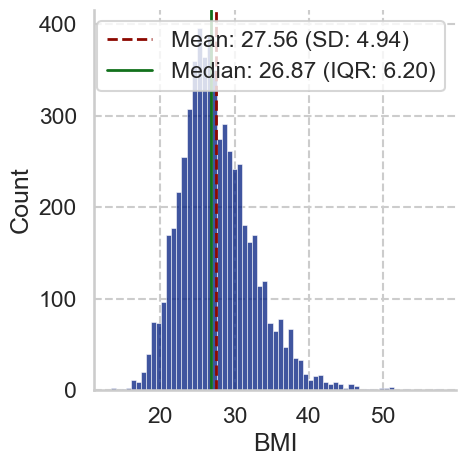

Age


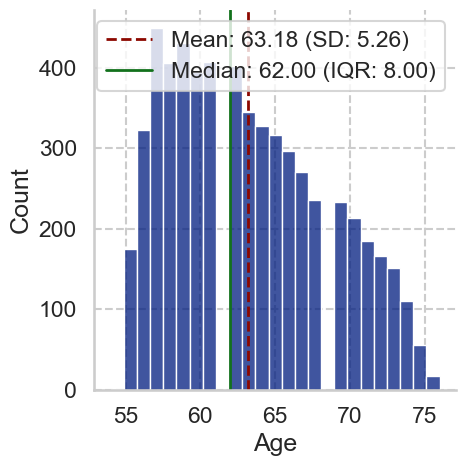

height


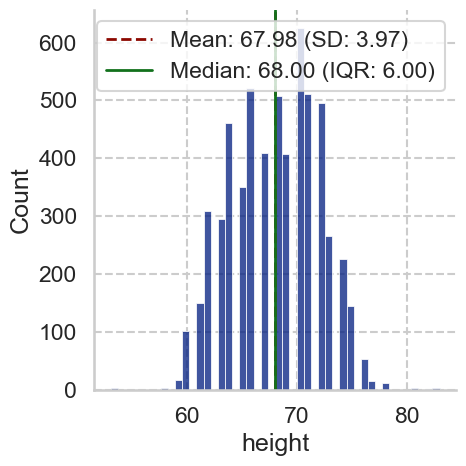

weight


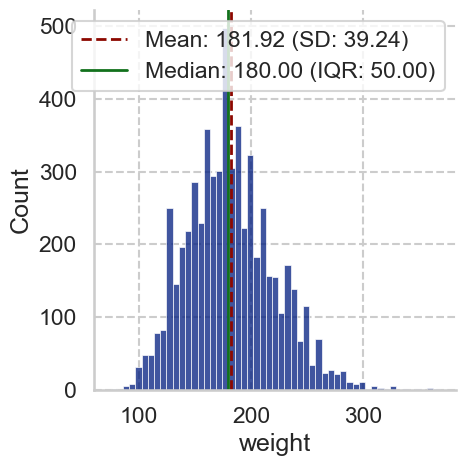

smokeage


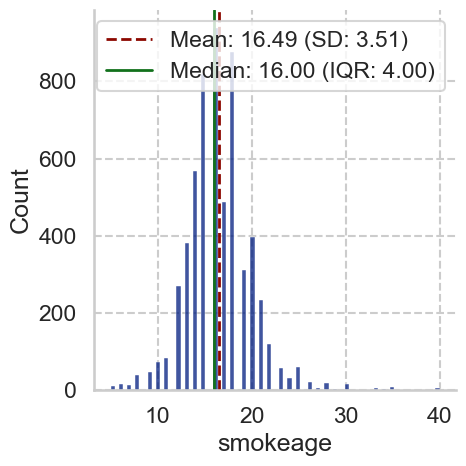

smokeday


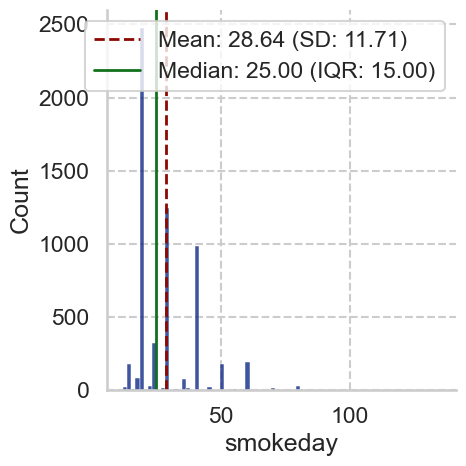

smokeyr


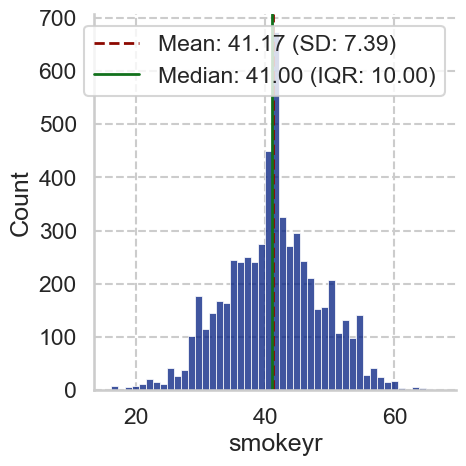

pkyr


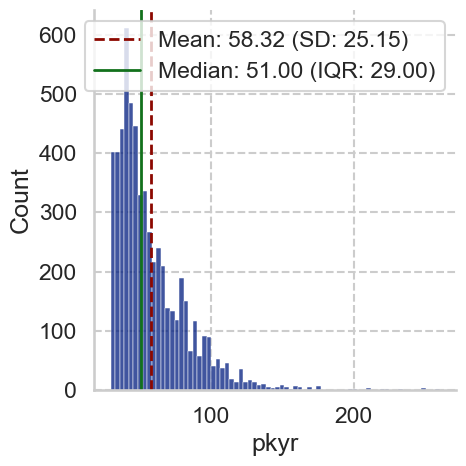

NoduleCounts


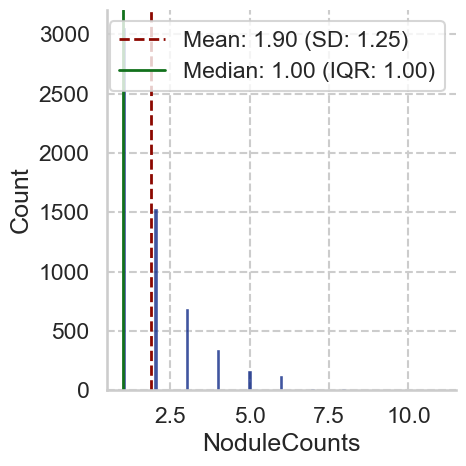

Diameter_mm


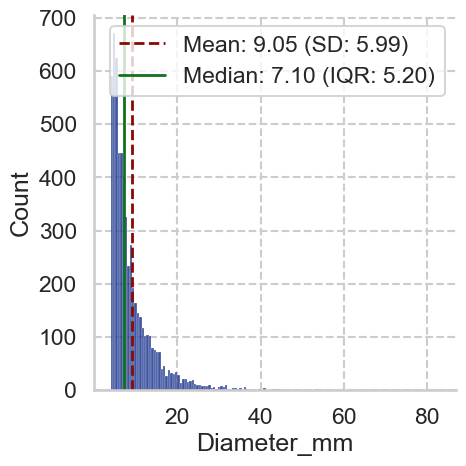

SliceCount


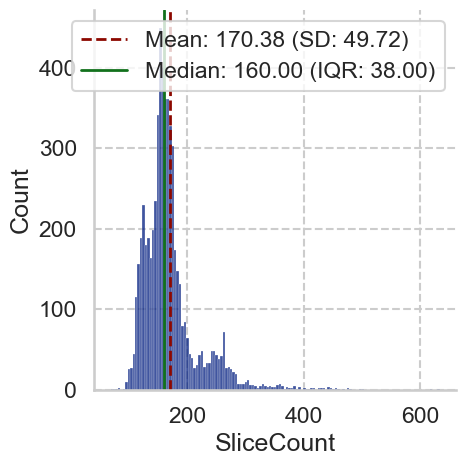

In [5]:
nlst_scan_test, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=False, bin_num=False)
for category in nlst_democols_og['num']:
    if category == 'nodule':
        continue
    for col in nlst_democols_og['num'][category]:
        print(col)
        sns.displot(nlst_scan_test, x=col)
        # Calculate mean and median
        mean = np.nanmean(nlst_scan_test[col])
        median = np.nanmedian(nlst_scan_test[col])
        std = np.nanstd(nlst_scan_test[col])
        iqr = nlst_scan_test[col].quantile(0.75) - nlst_scan_test[col].quantile(0.25)

        # Add vertical lines for mean and median
        plt.axvline(mean, color='r', linestyle='--', label=f'Mean: {mean:.2f} (SD: {std:.2f})')
        plt.axvline(median, color='g', linestyle='-', label=f'Median: {median:.2f} (IQR: {iqr:.2f})')

        # Add a legend
        plt.legend()
        plt.show()

# Materials

## Demographic characteristics of the NLST validation sets (n=5911 scans, n=1172 scans).

In [6]:
nlst_5911, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
nlst_1172, nlst_democols, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=True, sybil=True, pretty=True, bin_num=False)
len(nlst_5911), len(nlst_1172)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:473: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:473: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


(5911, 1172)

In [7]:
nlstval_full_mal = nlst_5911.query('label == 1')
nlstval_full_ben = nlst_5911.query('label == 0')
print('full:', len(nlstval_full_ben), 'ben', len(nlstval_full_mal), 'mal')

nlstval_some_mal = nlst_1172.query('label == 1')
nlstval_some_ben = nlst_1172.query('label == 0')
print('some:', len(nlstval_some_ben), 'ben', len(nlstval_some_mal), 'mal')

full: 5330 ben 581 mal
some: 1045 ben 127 mal


In [8]:
validation_sets = {
    "Full (malignant)": nlstval_full_mal,
    "Full (benign)": nlstval_full_ben,
    # "Full (all)": nlst_5911,
    "Partial (malignant)": nlstval_some_mal,
    "Partial (benign)": nlstval_some_ben,
    # "Partial (all)": nlst_1172,
}

In [9]:
df = data.combine_diff_dfs(nlst_democols['cat'], data.diffs_category_prevalence, validation_sets)
# df[(df['category'] == "demo") & (df['attribute'].isin(['Gender', 'race', 'educat', 'Married', 'marital', 'ethnic']))]

In [10]:
for s in validation_sets:
    df[f"{s}_info"] = df.apply(lambda x: f'{0 if np.isnan(x[f"{s}_freq"]) else int(x[f"{s}_freq"])} ({0 if np.isnan(x[f"{s}_norm"]) else np.around(x[f"{s}_norm"], 1)})', axis=1)

df_out = df[
    (df['category'] == "Demographics") 
    # & (df['attribute'].isin(['Gender', 'Race', 'Education Status', 'Marital Status', 'Ethnic']))
][['attribute', 'value'] + [f"{s}_info" for s in validation_sets]].dropna(axis=0)

In [11]:
df_out_idx = pd.MultiIndex.from_frame(df_out[['attribute', 'value']])
df_out2 = df_out.set_index(df_out_idx)[[f"{s}_info" for s in validation_sets]]

multicol_idx = pd.MultiIndex.from_tuples([
    ('Full Dataset (n=5911 Scans)', 'Malignant (n=581)'),
    ('Full Dataset (n=5911 Scans)', 'Benign (n=5330)'),
    # ('Full Dataset (n=5911 Scans)', 'Total'),
    ('Partial Dataset (n=1172 Scans)', 'Malignant (n=127)'),
    ('Partial Dataset (n=1172 Scans)', 'Benign (n=1045)'),
    # ('Partial Dataset (n=1172 Scans)', 'Total'),
])

df_out2.columns = multicol_idx

In [12]:
print(df_out2.style.to_latex(buf=f"{TAB_DIR}/datasetDemos.tex",
    hrules=True, label='tab:datasetDemos', environment='table*', column_format='ll|rrr|rrr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'Demographic characteristics of the NLST validation sets (n={len(nlst_5911)} scans, n={len(nlst_1172)} scans).'))

None


In [13]:
num_df = data.combine_diff_dfs(nlst_democols['num'], data.diffs_numerical_means, validation_sets)
num_df = num_df[
    (num_df['category'] == "Demographics") & (num_df['value'].isin(['Median (IQR)']))
    # & (df['attribute'].isin(['Gender', 'Race', 'Education Status', 'Marital Status', 'Ethnic']))
][['attribute', 'value'] + [f"{s}" for s in validation_sets]].dropna(axis=0)
num_df = num_df.set_index(pd.MultiIndex.from_frame(num_df[['attribute', 'value']]))[[f"{s}" for s in validation_sets]]
num_df.columns = multicol_idx

In [14]:
df_out2 = pd.concat([df_out2, num_df], axis=0)
df_out2

Full Dataset (n=5911 Scans)  \
                                                         Malignant (n=581)   
attribute                  value                                             
BMI Class                  25 or Above                          372 (64.0)   
                           Below 25                             209 (36.0)   
Education Status           8th grade or less                       9 (1.5)   
                           9th-11th grade                         32 (5.5)   
                           Associate Degree                     126 (21.7)   
                           Bachelors Degree                      96 (16.5)   
                           Graduate School                       76 (13.1)   
                           HS Graduate / GED                    141 (24.3)   
                           Post-HS training                      87 (15.0)   
Gender                     Female                               244 (42.0)   
                           Male                                 337 (58.0)   
Married                    False                                197 (33.9)   
                           True                                 384 (66.1)   
HS Education               False                                   9 (1.5)   
                           True                                 572 (98.5)   
Non-Hispanic White         False                                  55 (9.5)   
                           True                                 526 (90.5)   
Unfinished Education Level False                                423 (72.8)   
                           True                                 158 (27.2)   
White or Black             Black                                  28 (4.8)   
                           White                                530 (91.2)   
Marital Status             Divorced                             125 (21.5)   
                           Married                              384 (66.1)   
                           Never Married                          16 (2.8)   
                           Separated                               5 (0.9)   
                           Widowed                                49 (8.4)   
Ethnicity                  Hispanic/Latino                         4 (0.7)   
                           Not Hispanic/Latino                  574 (98.8)   
Race                       Asian                                   6 (1.0)   
                           Black                                  28 (4.8)   
                           More than one race                      6 (1.0)   
                           Native American                         8 (1.4)   
                           Native Hawaiian                         1 (0.2)   
                           White                                530 (91.2)   
BMI                        Median (IQR)                             26 (4)   
Age                        Median (IQR)                             64 (8)   
Height                     Median (IQR)                             68 (6)   
Weight                     Median (IQR)                           175 (50)   

                                                                \
                                               Benign (n=5330)   
attribute                  value                                 
BMI Class                  25 or Above             3640 (68.3)   
                           Below 25                1690 (31.7)   
Education Status           8th grade or less         102 (1.9)   
                           9th-11th grade            258 (4.8)   
                           Associate Degree        1175 (22.0)   
                           Bachelors Degree         817 (15.3)   
                           Graduate School          778 (14.6)   
                           HS Graduate / GED       1338 (25.1)   
                           Post-HS training         765 (14.4)   
Gender                     Female                  2226 

In [15]:
print(df_out2.style.format(precision=1, na_rep='-').to_latex(
    buf=f"{TAB_DIR}/datasetDemos.tex",
    hrules=True, label='tab:datasetDemos', environment='table*', column_format='ll|rr|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption=f'Demographic characteristics of the NLST validation sets (n={len(nlst_5911)} scans, n={len(nlst_1172)} scans). HS = High School.'))

None


## DLCST vs. NLST

In [16]:
nlst_valset, nlst_cols, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
display(nlst_valset['Emphysema in Scan'])
dlcst_democols = {
    'cat': {'demo': ['Sex'], 'other': ['FamilyHistoryLungCa', 'Emphysema']},
    'num': {'demo': ['Age'], 'other': ['NoduleCountPerScan']}
}
dlcst_preds = pd.read_csv(f"{TEAMS_DIR}/dlcst/calibrated_dlcst_thijmen_kiran_sybil_malignancy_estimation_results.csv", header=0)
display(dlcst_preds)
dlcst_valset, dlcst_cols = data.nlst_pretty_labels(dlcst_preds, dlcst_democols)

for typ in dlcst_cols:
    for cat in dlcst_cols[typ]:
        for att in dlcst_cols[typ][cat]:
            print(att)
            print(pd.unique(dlcst_valset[att]))
            print(pd.unique(nlst_valset[att]))

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:473: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


0        False
1        False
2         True
4         True
5         True
         ...  
10168    False
10179    False
10180    False
10181    False
10182     True
Name: Emphysema in Scan, Length: 5911, dtype: bool

PatientID  StudyDate                        SeriesInstanceUID  Age  Sex  \
0            4   20050124  1.2.840.113704.1.111.4964.1106577805.10   55    2   
1           35   20051208  1.2.840.113704.1.111.5776.1134059140.11   56    1   
2           38   20060109  1.2.840.113704.1.111.2004.1136823831.14   62    2   
3           47   20051214  1.2.840.113704.1.111.8148.1134579622.14   57    1   
4           56   20051213  1.2.840.113704.1.111.2744.1134487263.11   64    1   
..         ...        ...                                      ...  ...  ...   
594       4057   20060314  1.2.840.113704.1.111.4796.1142355218.14   69    1   
595       4063   20060313  1.2.840.113704.1.111.5104.1142267340.10   55    1   
596       4079   20060328  1.2.840.113704.1.111.1308.1143556124.11   52    2   
597       4098   20060403  1.2.840.113704.1.111.5848.1144079789.11   54    1   
598       4099   20060403  1.2.840.113704.1.111.5112.1144079519.11   51    2   

     FamilyHistoryLungCa  Emphysema  NoduleCountPerScan  sybil_year1  \
0                      0          0                   9     0.021629   
1                      1          1                   2     0.001170   
2                      0          1                   4     0.001784   
3                      0          1                   1     0.003951   
4                      0          1                   3     0.000000   
..                   ...        ...                 ...          ...   
594                    0          1                   2     0.168810   
595                    0          1                   4     0.001965   
596                    0          0                   1     0.003951   
597                    0          1                   3     0.117795   
598                    0          1                   4     0.003951   

     sybil_year2  sybil_year3  sybil_year4  sybil_year5  sybil_year6  \
0       0.038573     0.071919     0.079270     0.095846     0.135681   
1       0.002554     0.007835     0.011039     0.018442     0.030460   
2       0.003870     0.007835     0.012797     0.019229     0.032957   
3       0.015674     0.025373     0.034010     0.040605     0.058852   
4       0.001574     0.003791     0.006847     0.010381     0.017287   
..           ...          ...          ...          ...          ...   
594     0.273494     0.257961     0.294720     0.327062     0.383196   
595     0.006793     0.013618     0.017289     0.021685     0.035951   
596     0.011459     0.025373     0.034010     0.040101     0.058852   
597     0.167839     0.189976     0.217799     0.229753     0.300137   
598     0.015674     0.025373     0.034919     0.043507     0.063896   

     PanCan2b  Ensemble_Kiran  thijmen_mean  label  Ensemble_Kiran_cal  \
0    0.053366        0.082652      0.166209      0            0.119066   
1    0.009543        0.000408      0.003368      0            0.018347   
2    0.006734        0.002702      0.065888      0            0.035409   
3    0.007944        0.084158      0.423341      0            0.119856   
4    0.000899        0.000013      0.005590      0            0.005651   
..        ...             ...           ...    ...                 ...   
594  0.380198        0.893933      0.682322      0            0.439657   
595  0.000000        0.000099      0.103020      0            0.011303   
596  0.039054        0.070744      0.121373      0            0.112500   
597  0.134158        0.452513      0.347016      0            0.241085   
598  0.009513        0.001050      0.027908      0            0.025458   

     thijmen_mean_cal  
0            0.097887  
1            0.006485  
2            0.048255  
3            0.226322  
4            0.008965  
..                ...  
594          0.400826  
595          0.067322  
596          0.076349  
597          0.185779  
598          0.026218  

[599 rows x 20 columns]

Gender
['Female' 'Male']
['Female' 'Male']
Family History of LC
[False  True]
[ True False]
Emphysema in Scan
[False  True]
[False  True]
Age
[55 56 62 57 64 61 66 50 53 63 51 58 52 59 60 54 70 65 67 68 69 71 75]
[61 62 56 57 69 70 71 63 64 65 66 58 67 59 60 55 73 74 75 68 72 76 54]
Nodules Per Scan
[9 2 4 1 3 6 5 7 8]
[ 1  5  4  2  3  6  7  8  9 11 10]


c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:473: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


In [17]:
popshift_check = {
    "NLST_mal": nlst_valset.query('label == 1'),
    "NLST_ben": nlst_valset.query('label == 0'),
    # "NLST_full": nlst_valset,
    "DLCST_mal": dlcst_valset.query('label == 1'),
    "DLCST_ben": dlcst_valset.query('label == 0'),
    # "DLCST_full": dlcst_valset,   
}

popshift_multi_idx = pd.MultiIndex.from_tuples([
    ('NLST Validation (n=5911 Scans)', 'Malignant (n=581)'),
    ('NLST Validation (n=5911 Scans)', 'Benign (n=5330)'),
    # ('NLST Validation (n=5911 Scans)', 'Total'),
    ('DLCST Validation (n=599 Scans)', 'Malignant (n=59)'),
    ('DLCST Validation (n=599 Scans)', 'Benign (n=540)'),
    # ('DLCST Validation (n=599 Scans)', 'Total'),
])

df_popshift = data.combine_diff_dfs(dlcst_cols['cat'], dfsets=popshift_check, dispdf=False)
for s in popshift_check:
    df_popshift[f"{s}_info"] = df_popshift.apply(lambda x: f'{0 if np.isnan(x[f"{s}_freq"]) else int(x[f"{s}_freq"])} ({0 if np.isnan(x[f"{s}_norm"]) else np.around(x[f"{s}_norm"], 1)})', axis=1)

cat_multiidx = pd.MultiIndex.from_frame(df_popshift[['attribute', 'value']])
df_popshift = df_popshift.set_index(cat_multiidx)[[f"{s}_info" for s in popshift_check]]
df_popshift.columns = popshift_multi_idx

In [18]:
num_popshift = data.combine_diff_dfs(dlcst_cols['num'], df_func=data.diffs_numerical_means, dfsets=popshift_check, dispdf=False)
num_popshift = num_popshift[
    (num_popshift['category'] == "Demographics") & (num_popshift['value'].isin(['Median (IQR)']))
    # & (df['attribute'].isin(['Gender', 'Race', 'Education Status', 'Marital Status', 'Ethnic']))
][['attribute', 'value'] + [f"{s}" for s in popshift_check]].dropna(axis=0)
num_popshift = num_popshift.set_index(pd.MultiIndex.from_frame(num_popshift[['attribute', 'value']]))[[f"{s}" for s in popshift_check]]
num_popshift.columns = popshift_multi_idx

In [19]:
df_popshift = pd.concat([df_popshift, num_popshift], axis=0)
df_popshift

NLST Validation (n=5911 Scans)  \
                                               Malignant (n=581)   
attribute            value                                         
Gender               Female                           244 (42.0)   
                     Male                             337 (58.0)   
Family History of LC False                            401 (69.0)   
                     True                             180 (31.0)   
Emphysema in Scan    False                            317 (54.6)   
                     True                             264 (45.4)   
Age                  Median (IQR)                         64 (8)   

                                                   \
                                  Benign (n=5330)   
attribute            value                          
Gender               Female           2226 (41.8)   
                     Male             3104 (58.2)   
Family History of LC False            3983 (74.7)   
                     True             1347 (25.3)   
Emphysema in Scan    False            3438 (64.5)   
                     True             1892 (35.5)   
Age                  Median (IQR)          62 (8)   

                                  DLCST Validation (n=599 Scans)  \
                                                Malignant (n=59)   
attribute            value                                         
Gender               Female                            27 (45.8)   
                     Male                              32 (54.2)   
Family History of LC False                             43 (72.9)   
                     True                              16 (27.1)   
Emphysema in Scan    False                             15 (25.4)   
                     True                              44 (74.6)   
Age                  Median (IQR)                         62 (7)   

                                                  
                                  Benign (n=540)  
attribute            value                        
Gender               Female           249 (46.1)  
                     Male             291 (53.9)  
Family History of LC False            454 (84.1)  
                     True              86 (15.9)  
Emphysema in Scan    False            179 (33.1)  
                     True             361 (66.9)  
Age                  Median (IQR)         58 (7)

In [20]:
print(df_popshift.style.format(precision=1, na_rep='-').to_latex(
    buf=f"{TAB_DIR}/populationShift.tex",
    hrules=True, label='tab:populationShift', environment='table*', column_format='ll|rr|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption=f'Demographic characteristics of the DLCST validation set (n=599 scans), compared to those from the NLST validation set (n=5911 scans).'))

None


# Methods

### Thresholds from policies on validation sets.

In [21]:
policies = (
    ("Sensitivity", 0.9),
    # ("Sensitivity", 1.0),
    ("Specificity", 0.9),
    # ("Specificity", 1.0),
    # ("Youden J", 1.0),  ## Max J statistic
)

In [22]:
DLCST_MODELCOLS = {
    "Venkadesh": "Ensemble_Kiran_cal",
    "De Haas Combined": "thijmen_mean_cal",
    "PanCan2b": "PanCan2b",
    "Sybil (Year 1)": "sybil_year1",
}
dlcst_policies, _ = threshold.get_threshold_policies(dlcst_preds, models=DLCST_MODELCOLS, policies=policies, brock=True)

In [23]:
NLST_1172_MODELCOLS = {
    "Venkadesh": "DL_cal",
    "De Haas Combined": "Thijmen_mean_cal",
    "De Haas Local": "Thijmen_local_cal",
    "De Haas Global (Hidden Nodule)": "Thijmen_global_hidden_cal",
    "De Haas Global (Shown Nodule)": "Thijmen_global_show_cal",
    "Sybil (Year 1)": "sybil_year1",
    "PanCan2b": "PanCan2b",
}
nlst_1172, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=True, sybil=True, pretty=True, bin_num=False)
nlst_1172_policies, _ = threshold.get_threshold_policies(nlst_1172, models=NLST_1172_MODELCOLS, policies=policies, brock=True)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:473: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


In [24]:
NLST_5911_MODELCOLS = {
    "Venkadesh": "DL_cal",
    # "De Haas Combined": "Thijmen_mean_cal",
    "De Haas Local": "Thijmen_local_cal",
    "De Haas Global (Hidden Nodule)": "Thijmen_global_hidden_cal",
    "De Haas Global (Shown Nodule)": "Thijmen_global_show_cal",
    "Sybil (Year 1)": "sybil_year1",
    "PanCan2b": "PanCan2b",
}
nlst_5911, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
nlst_5911_policies, _ = threshold.get_threshold_policies(nlst_5911, models=NLST_5911_MODELCOLS, policies=policies, brock=True)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:473: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


In [25]:
policy_dfs = {
    "DLCST (n=599)": dlcst_policies.copy(deep=True), 
    "NLST Partial (n=1172)": nlst_1172_policies.copy(deep=True), 
    "NLST Full (n=5911)": nlst_5911_policies.copy(deep=True)
}

for val in policy_dfs:
    if 'Brock' in policy_dfs[val].columns:
        policy_dfs[val].drop(columns='Brock', inplace=True)
    policy_dfs[val].rename(columns={'Sensitivity=0.9': '90\% Sensitivity', 'Specificity=0.9': '90\% Specificity'}, inplace=True)

combined_policies = pd.concat(policy_dfs, axis=1).sort_index(ascending=False)
combined_policies

DLCST (n=599)                   \
                               90\% Sensitivity 90\% Specificity   
Venkadesh                                 0.134            0.204   
Sybil (Year 1)                            0.001            0.018   
PanCan2b                                  0.020            0.093   
De Haas Local                               NaN              NaN   
De Haas Global (Shown Nodule)               NaN              NaN   
De Haas Global (Hidden Nodule)              NaN              NaN   
De Haas Combined                          0.099            0.193   

                               NLST Partial (n=1172)                   \
                                    90\% Sensitivity 90\% Specificity   
Venkadesh                                      0.026            0.229   
Sybil (Year 1)                                 0.003            0.058   
PanCan2b                                       0.014            0.168   
De Haas Local                                  0.049            0.214   
De Haas Global (Shown Nodule)                  0.038            0.308   
De Haas Global (Hidden Nodule)                 0.060            0.235   
De Haas Combined                               0.069            0.261   

                               NLST Full (n=5911)                   
                                 90\% Sensitivity 90\% Specificity  
Venkadesh                                   0.048            0.220  
Sybil (Year 1)                              0.003            0.058  
PanCan2b                                    0.015            0.165  
De Haas Local                               0.044            0.212  
De Haas Global (Shown Nodule)               0.068            0.300  
De Haas Global (Hidden Nodule)              0.066            0.241  
De Haas Combined                              NaN              NaN

In [26]:
print(combined_policies.style.format(precision=3, na_rep='\\verb|-|').to_latex(
    buf=f"{TAB_DIR}/thresholds.tex",
    hrules=True, label='tab:thresholds', environment='table*', column_format='l|rr|rr|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='Thresholds used to evaluate model performance on DLCST and both NLST validation datasets. All models are also evaluated on the ILST moderate risk threshold of 6\% (0.06) \cite{Lim2020-ilst}.'))

None


# Results

In [27]:
model_column_rename = {
    'Venkadesh': 'Venkadesh',
    'de Haas': 'De Haas Combined', 
    'de Haas Combined': 'De Haas Combined', 
    'Sybil year 1': 'Sybil (Year 1)', 
    'de Haas Local': 'De Haas Local',
    'de Haas Global (hidden nodule)': 'De Haas Global (Hidden Nodule)',
    'de Haas Global (shown nodule)': 'De Haas Global (Shown Nodule)',
    'PanCan2b': 'PanCan2b'
}

In [28]:
def prettify_result_val(attribute, group):
    if ">" in attribute:
        attribute_value_split_list = attribute.split(">")
        new_attribute = data.rename_cols[attribute_value_split_list[0].strip()] + " Group"

        if group == 'ALL':
            return new_attribute, 'ALL'
                                         
        new_group = "True"
        if str(group).lower() in ['true', '1', '1.0']:
            new_group = f"Above {int(attribute_value_split_list[1].strip())}"
        else:
            new_group = f"{int(attribute_value_split_list[1].strip())} or Below"

    else:    
        new_attribute = data.rename_cols[attribute]
        if group == 'ALL':
            return new_attribute, 'ALL'
        
        new_group = group
        if attribute in data.keys:
            if group == 'True':
                new_group = True
            elif group == 'False':
                new_group = False    
            elif pd.isna(group):
                new_group = None
            else:
                new_group = int(float(group))
            new_group = data.keys[attribute][new_group]
        
        elif attribute in data.boolean_cols:
            if str(group).lower() == 'true' or str(group) == '1':
                new_group = "True"
            elif str(group).lower() == 'false' or str(group) == '0':
                new_group = "False"

    return new_attribute, new_group

## ROC Tables

In [29]:
TABLE_SCORE_PRECISION = 2
def pretty_interval(row, precision, group_num=1, metric='AUC'):
    return f"{row[f'{metric}_{group_num}']:.{precision}f} ({row[f'{metric}-CI-lo_{group_num}']:.{precision}f}, {row[f'{metric}-CI-hi_{group_num}']:.{precision}f})"

In [30]:
def roc_results_pretty(df, model_order_0, precision=TABLE_SCORE_PRECISION):
    model_order = [model_column_rename[m] for m in model_order_0]
    df.rename(index=model_column_rename, inplace=True)
    df.reset_index(inplace=True, names='model')
    
    ## Get AUC info in nice interval notation.
    df['Group_1_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=1), axis=1)
    df['Group_2_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=2), axis=1)

    df1 = df[['model', 'category', 'attribute', 'Group_1', 'Group_1_AUC', 'Group_1_mal']].rename(columns={'Group_1': 'Group', 'Group_1_AUC': 'ROC AUC', 'Group_1_mal': 'Malignant Scans'})
    df2 = df[['model', 'category', 'attribute', 'Group_2', 'Group_2_AUC', 'Group_2_mal', 'p']].rename(columns={'Group_2': 'Group', 'Group_2_AUC': 'ROC AUC', 'Group_2_mal': 'Malignant Scans'})
    df_res = pd.concat([df1, df2])

    df_res['Category'] = df_res.apply(lambda row: data.rename_types[row['category']], axis=1)
    df_res['Attribute'] = df_res.apply(lambda row: prettify_result_val(row['attribute'], row['Group'])[0], axis=1)
    df_res['Group'] = df_res.apply(lambda row: prettify_result_val(row['attribute'], row['Group'])[1], axis=1)
    df_res['p'] = df_res.apply(lambda row: data.truncate_p(row['p']), axis=1)
    df_res = df_res.set_index(pd.MultiIndex.from_frame(df_res[['Category', 'Attribute', 'Group']]))

    model_results = {m: dfm[['ROC AUC', 'p']] for m, dfm in df_res.groupby('model')}
    df_out = pd.concat(model_results, axis=1)
    df_out['Malignant Scans'] = df_res['Malignant Scans'].drop_duplicates()
    df_out = df_out.sort_values(by='Malignant Scans', ascending=False)
    df_out = df_out.sort_index(ascending=True, level=['Category', 'Attribute'], sort_remaining=False)[model_order + ['Malignant Scans']]
    return df_out

### DLCST

In [31]:
dlcst_results = pd.read_csv(f"{RESULTS_DIR}/auroc-dlcst-599.csv", index_col=0)
dlcst_model_order = ['Venkadesh', 'de Haas', 'Sybil year 1', 'PanCan2b']
dlcst_out = roc_results_pretty(dlcst_results, dlcst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])
dlcst_out_demos = dlcst_out.xs('Demographics', level='Category')
dlcst_out_demos

C:\Users\shaur\AppData\Local\Temp\ipykernel_11792\1842769948.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dlcst_out = roc_results_pretty(dlcst_results, dlcst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])


Venkadesh         De Haas Combined        \
                                 ROC AUC     p            ROC AUC     p   
Attribute Group                                                           
Age Group Above 61     0.92 (0.87, 0.97)  None  0.91 (0.85, 0.96)  None   
          61 or Below  0.92 (0.85, 0.97)   .99  0.92 (0.86, 0.97)   .78   
Gender    Male         0.91 (0.84, 0.96)  None  0.90 (0.84, 0.96)  None   
          Female       0.94 (0.91, 0.97)   .44  0.95 (0.91, 0.98)   .37   

                          Sybil (Year 1)                 PanCan2b        
                                 ROC AUC     p            ROC AUC     p  
Attribute Group                                                          
Age Group Above 61     0.86 (0.78, 0.94)  None  0.85 (0.79, 0.91)  None  
          61 or Below  0.86 (0.78, 0.93)   .98  0.90 (0.84, 0.95)   .46  
Gender    Male         0.87 (0.78, 0.94)  None  0.91 (0.86, 0.95)  None  
          Female       0.86 (0.78, 0.93)   .88  0.86 (0.79, 0.92)   .35

In [32]:
print(dlcst_out_demos.style.format(na_rep='').to_latex(
    buf=f"{TAB_DIR}/resDLCSTdemoROC.tex",
    hrules=True, label='tab:resDLCSTdemoROC', environment='table*', column_format=f'll{"|lr"*len(dlcst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='ROC AUC with 95\% Confidence Intervals for models on demographic characteristics when evaluated on the DLCST validation set (599 scans), including p values. No significant demographic biases were found from any of our models on the DLCST cohort.'))

None


### NLST (for Tijmen's combined model only.)

In [33]:
nlst_demos_to_include = ['Age Group', 'Gender', 'Race', 'HS Education', 'Height Group', 'Weight Group', 'BMI Class']

In [34]:
nlst_tijmen_scan_res = pd.read_csv(f"{RESULTS_DIR}/auroc-nlst-1172.csv", index_col=0)
# nlst_tijmen_model_order = ['Venkadesh', 'de Haas Combined', 'Sybil year 1', 'PanCan2b']
nlst_tijmen_model_order = ['de Haas Combined', 'de Haas Local', 'de Haas Global (hidden nodule)']
nlst_tijmen_scan_out = roc_results_pretty(nlst_tijmen_scan_res, nlst_tijmen_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])
nlst_tijmen_scan_out_demos = nlst_tijmen_scan_out.xs('Demographics', level='Category').query('Attribute in @nlst_demos_to_include')
nlst_tijmen_scan_out_demos

C:\Users\shaur\AppData\Local\Temp\ipykernel_11792\2677927955.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  nlst_tijmen_scan_out = roc_results_pretty(nlst_tijmen_scan_res, nlst_tijmen_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])


De Haas Combined            De Haas Local        \
                                     ROC AUC     p            ROC AUC     p   
Attribute    Group                                                            
Age Group    Above 61      0.86 (0.82, 0.90)  None  0.85 (0.81, 0.90)  None   
             61 or Below   0.88 (0.82, 0.92)   .73  0.88 (0.83, 0.93)   .45   
BMI Class    25 or Above   0.87 (0.83, 0.90)  None  0.87 (0.83, 0.91)  None   
             Below 25      0.87 (0.82, 0.92)   .91  0.85 (0.79, 0.90)   .57   
Gender       Male          0.87 (0.84, 0.91)  None  0.87 (0.82, 0.91)  None   
             Female        0.86 (0.80, 0.91)   .69  0.87 (0.81, 0.91)   .98   
HS Education True          0.87 (0.84, 0.90)  None  0.87 (0.83, 0.90)  None   
             False         0.82 (0.58, 1.00)   .72  0.93 (0.79, 1.00)   .52   
Height Group Above 68      0.87 (0.83, 0.91)  None  0.86 (0.82, 0.91)  None   
             68 or Below   0.87 (0.82, 0.92)   .91  0.87 (0.83, 0.92)   .83   
Race         White         0.87 (0.84, 0.90)  None  0.87 (0.83, 0.90)  None   
             Black         0.85 (0.71, 0.95)   .73  0.80 (0.62, 0.94)   .43   
Weight Group 180 or Below  0.86 (0.82, 0.90)  None  0.86 (0.82, 0.90)  None   
             Above 180     0.87 (0.83, 0.91)   .83  0.87 (0.82, 0.92)   .71   

                          De Haas Global (Hidden Nodule)        
                                                 ROC AUC     p  
Attribute    Group                                              
Age Group    Above 61                  0.77 (0.73, 0.82)  None  
             61 or Below               0.77 (0.71, 0.82)   .91  
BMI Class    25 or Above               0.78 (0.74, 0.82)  None  
             Below 25                  0.75 (0.68, 0.81)   .49  
Gender       Male                      0.80 (0.75, 0.84)  None  
             Female                    0.72 (0.66, 0.78)   .13  
HS Education True                      0.77 (0.74, 0.81)  None  
             False                     0.56 (0.33, 0.80)   .15  
Height Group Above 68                  0.79 (0.74, 0.84)  None  
             68 or Below               0.75 (0.69, 0.81)   .39  
Race         White                     0.78 (0.74, 0.81)  None  
             Black                     0.89 (0.77, 0.98)   .11  
Weight Group 180 or Below              0.74 (0.69, 0.79)  None  
             Above 180                 0.80 (0.75, 0.85)   .17

In [35]:
print(nlst_tijmen_scan_out_demos.style.format(na_rep='').to_latex(
    buf=f"{TAB_DIR}/resNLSTtijmenROC.tex",
    hrules=True, label='tab:resNLSTtijmenROC', environment='table*', column_format=f'll{"|lr"*len(nlst_tijmen_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='ROC AUC with 95\% Confidence Intervals for the De Haas model and its constituent submodels on demographic characteristics when evaluated on the smaller NLST validation set (1172 scans), including p values. No significant demographic biases were found from the De Haas Combined model on this limited set of scans.'))

None


### NLST for all other models

In [36]:
nlst_scan_res = pd.read_csv(f"{RESULTS_DIR}/auroc-nlst-5911.csv", index_col=0)
nlst_model_order = pd.unique(list(nlst_scan_res.index))
nlst_scan_out = roc_results_pretty(nlst_scan_res, nlst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])
nlst_scan_out_demos = nlst_scan_out.xs('Demographics', level='Category').query('Attribute in @nlst_demos_to_include')
nlst_scan_out_demos

C:\Users\shaur\AppData\Local\Temp\ipykernel_11792\4136687277.py:2: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  nlst_model_order = pd.unique(list(nlst_scan_res.index))
C:\Users\shaur\AppData\Local\Temp\ipykernel_11792\4136687277.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  nlst_scan_out = roc_results_pretty(nlst_scan_res, nlst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])


Venkadesh            De Haas Local        \
                                     ROC AUC     p            ROC AUC     p   
Attribute    Group                                                            
Age Group    Above 61      0.88 (0.86, 0.90)  None  0.86 (0.85, 0.88)  None   
             61 or Below   0.90 (0.88, 0.92)   .14  0.88 (0.86, 0.91)   .33   
BMI Class    25 or Above   0.90 (0.88, 0.91)  None  0.87 (0.85, 0.89)  None   
             Below 25      0.88 (0.85, 0.90)   .32  0.87 (0.85, 0.90)   .91   
Gender       Male          0.89 (0.87, 0.91)  None  0.87 (0.85, 0.89)  None   
             Female        0.89 (0.87, 0.91)   .92  0.88 (0.86, 0.90)   .40   
HS Education True          0.89 (0.88, 0.91)  None  0.87 (0.86, 0.89)  None   
             False         0.72 (0.46, 0.96)   .07  0.86 (0.66, 1.00)   .87   
Height Group 68 or Below   0.89 (0.87, 0.91)  None  0.88 (0.86, 0.90)  None   
             Above 68      0.88 (0.86, 0.91)   .67  0.86 (0.84, 0.89)   .35   
Race         White         0.89 (0.88, 0.91)  None  0.87 (0.86, 0.89)  None   
             Black         0.82 (0.74, 0.89)   .14  0.81 (0.72, 0.89)   .21   
Weight Group 180 or Below  0.88 (0.87, 0.90)  None  0.87 (0.85, 0.89)  None   
             Above 180     0.89 (0.87, 0.91)   .65  0.87 (0.85, 0.89)   .95   

                          De Haas Global (Hidden Nodule)        \
                                                 ROC AUC     p   
Attribute    Group                                               
Age Group    Above 61                  0.79 (0.77, 0.81)  None   
             61 or Below               0.81 (0.79, 0.83)   .30   
BMI Class    25 or Above               0.80 (0.78, 0.82)  None   
             Below 25                  0.79 (0.76, 0.82)   .63   
Gender       Male                      0.81 (0.80, 0.83)  None   
             Female                    0.77 (0.74, 0.80)   .05   
HS Education True                      0.80 (0.78, 0.81)  None   
             False                     0.78 (0.62, 0.91)   .81   
Height Group 68 or Below               0.79 (0.76, 0.81)  None   
             Above 68                  0.80 (0.78, 0.83)   .48   
Race         White                     0.80 (0.78, 0.81)  None   
             Black                     0.83 (0.76, 0.90)   .45   
Weight Group 180 or Below              0.78 (0.75, 0.80)  None   
             Above 180                 0.82 (0.79, 0.84)   .05   

                          De Haas Global (Shown Nodule)        \
                                                ROC AUC     p   
Attribute    Group                                              
Age Group    Above 61                 0.86 (0.84, 0.87)  None   
             61 or Below              0.84 (0.82, 0.87)   .55   
BMI Class    25 or Above              0.87 (0.85, 0.88)  None   
             Below 25                 0.82 (0.80, 0.85)   .03   
Gender       Male                     0.85 (0.84, 0.87)  None   
             Female                   0.85 (0.83, 0.88)   .95   
HS Education True                     0.85 (0.84, 0.87)  None   
             False                    0.87 (0.72, 0.98)   .87   
Height Group 68 or Below              0.86 (0.84, 0.87)  None   
             Above 68                 0.85 (0.83, 0.87)   .82   
Race         White                    0.85 (0.84, 0.87)  None   
             Black                    0.85 (0.77, 0.92)   .98   
Weight Group 180 or Below             0.83 (0.81, 0.85)  None   
             Above 180                0.88 (0.86, 0.90)   .01   

                              Sybil (Year 1)                   PanCan2b        
                                     ROC AUC       p            ROC AUC     p  
Attribute    Group                                                             
Age Group    Above 61      0.84 (0.82, 0.86)    None  0.76 (0.74, 0.79)  None  
             61 or Below   0.85 (0.82, 0.88)     .67  0.81 (0.78, 0.83)   .05  
BMI Class    25 or Above   0.86 (0.84, 0.88)    None  0.81 (0.

In [37]:
print(nlst_scan_out_demos.style.format(na_rep='').to_latex(
    buf=f"{TAB_DIR}/resNLSTscanROC.tex",
    hrules=True, label='tab:resNLSTscanROC', environment='table*', column_format=f'll{"|lr"*len(nlst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='ROC AUC with 95\% Confidence Intervals for models on demographic characteristics when evaluated on the larger NLST validation set (5911 scans), including p values. Sybil has significant demographic biases against men, people above 68 inches tall, and married indivivduals.'))

None


## Threshold Plots

In [38]:
rename_policies = {'Sensitivity=0.9': '90% Sensitivity', 'Specificity=0.9': '90% Specificity', 'Brock': 'Brock ILST (6%)'}

rename_metrics = {
    'fpr': 'FPR',
    'fnr': 'FNR',
    'tpr': 'TPR',
    'tnr': 'TNR'
}

rename_metrics_hi = {f'{k}_hi': f'{v}_hi' for k, v in rename_metrics.items()}
rename_metrics_lo = {f'{k}_lo': f'{v}_lo' for k, v in rename_metrics.items()}

In [39]:
def threshold_stats_pretty(df, policies):
    policies.rename(columns=rename_policies, inplace=True)
    df['policy'] = df['policy'].replace(rename_policies)
    df['model'] = df['model'].replace(model_column_rename)
    
    df['category'] = df.apply(lambda row: data.rename_types[row['category']], axis=1)
    df['attribute2'] = df.apply(lambda row: prettify_result_val(row['attribute'], row['group'])[0], axis=1)
    df['group'] = df.apply(lambda row: prettify_result_val(row['attribute'], row['group'])[1], axis=1)
    df['attribute'] = df['attribute2']

    df.rename(columns=rename_metrics, inplace=True)
    df.rename(columns=rename_metrics_lo, inplace=True)
    df.rename(columns=rename_metrics_hi, inplace=True)

    return df, policies

### DLCST

In [40]:
dlcst_preds_pretty, _ = data.nlst_pretty_labels(dlcst_preds, dlcst_democols)

In [41]:
threshold_dlcst = pd.read_csv(f'{RESULTS_DIR}/threshold-perfs-dlcst-{len(dlcst_preds)}.csv', index_col=0)
threshold_dlcst, dlcst_policies = threshold_stats_pretty(threshold_dlcst, dlcst_policies)
# display(dlcst_policies)
# display(threshold_dlcst[['category', 'attribute', 'group', 'policy', 'model', 'FPR', 'FPR_lo', 'FPR_hi']])
# DLCST_MODELCOLS

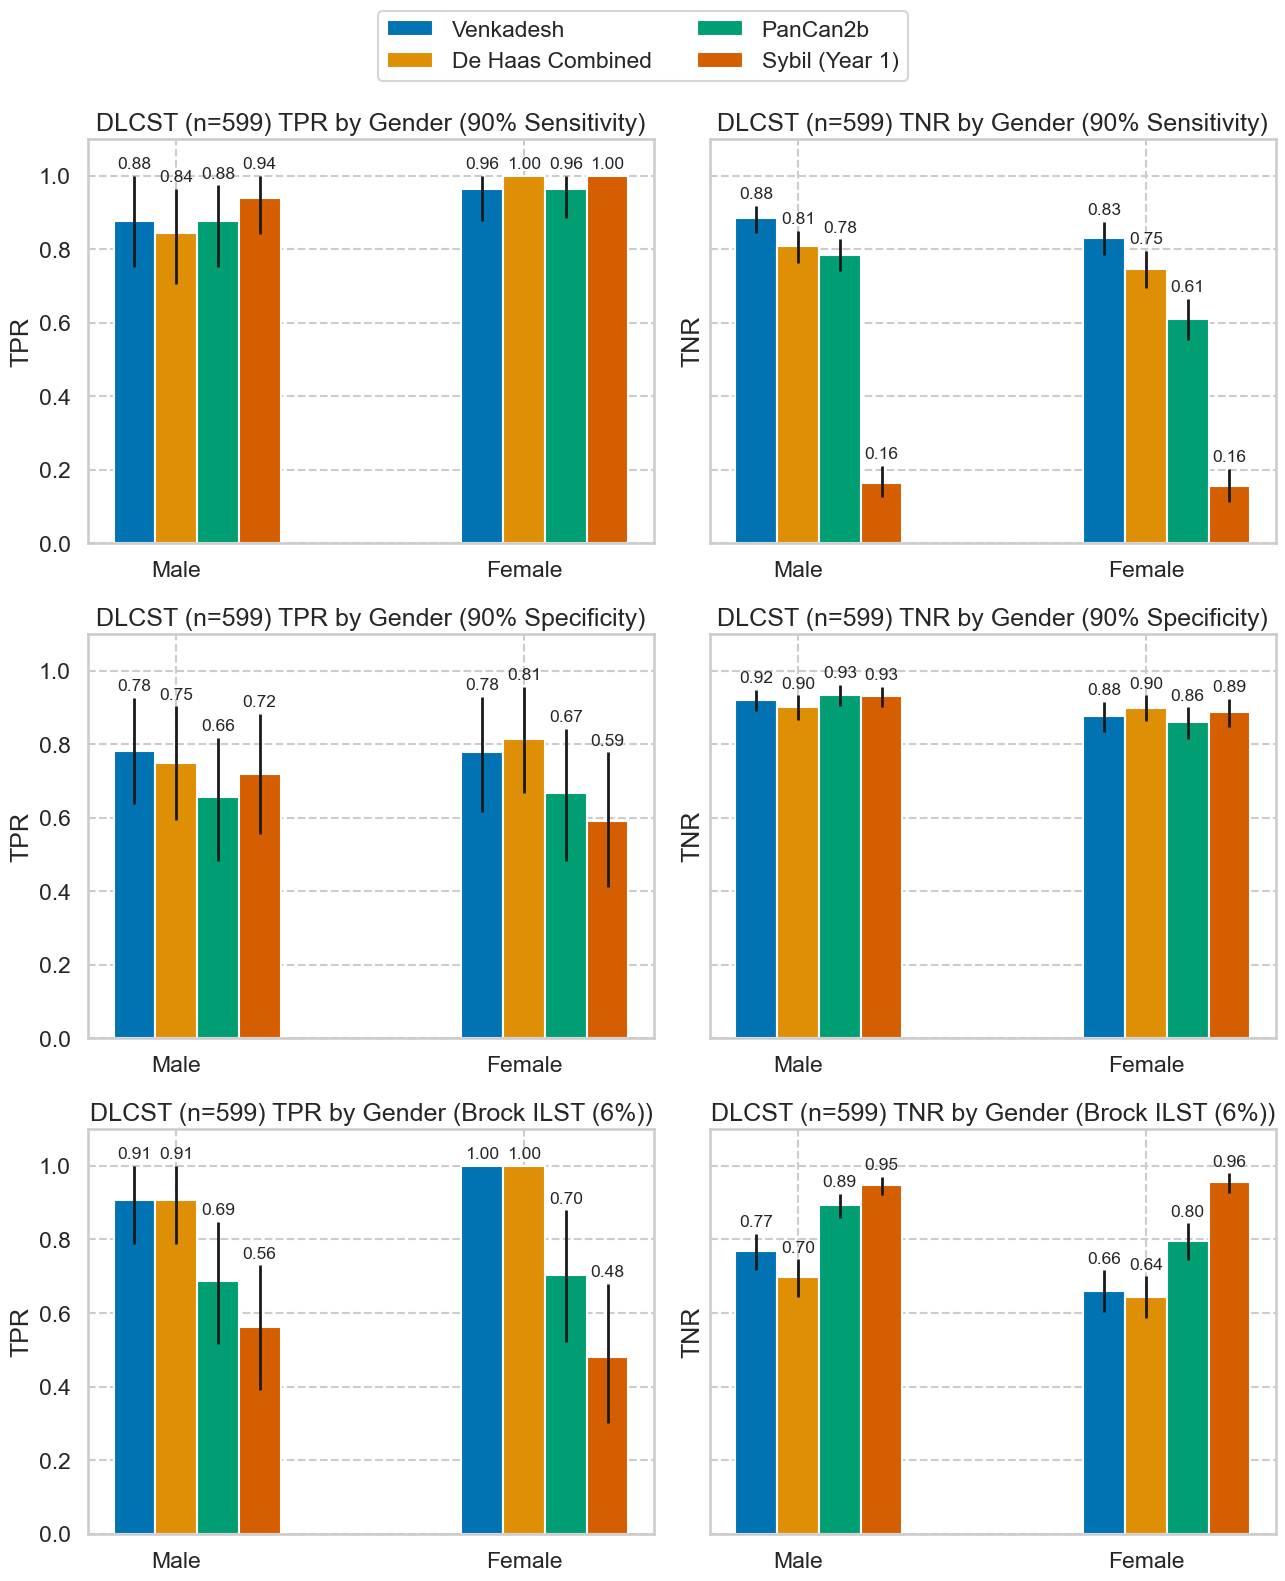

In [42]:
_ = threshold.plot_threshold_stats_subgroups(dlcst_preds_pretty, 'Gender', dataset_name='DLCST',
                                             policies=dlcst_policies, models=DLCST_MODELCOLS, 
                                             stats=threshold_dlcst.query('attribute == "Gender"'),
                                             plot_metrics=['TPR', 'TNR'], diff=False, show_mb_count=False,
                                             imgpath=f"{FIG_DIR}/thresholdDLCSTsex.png"
                                            )

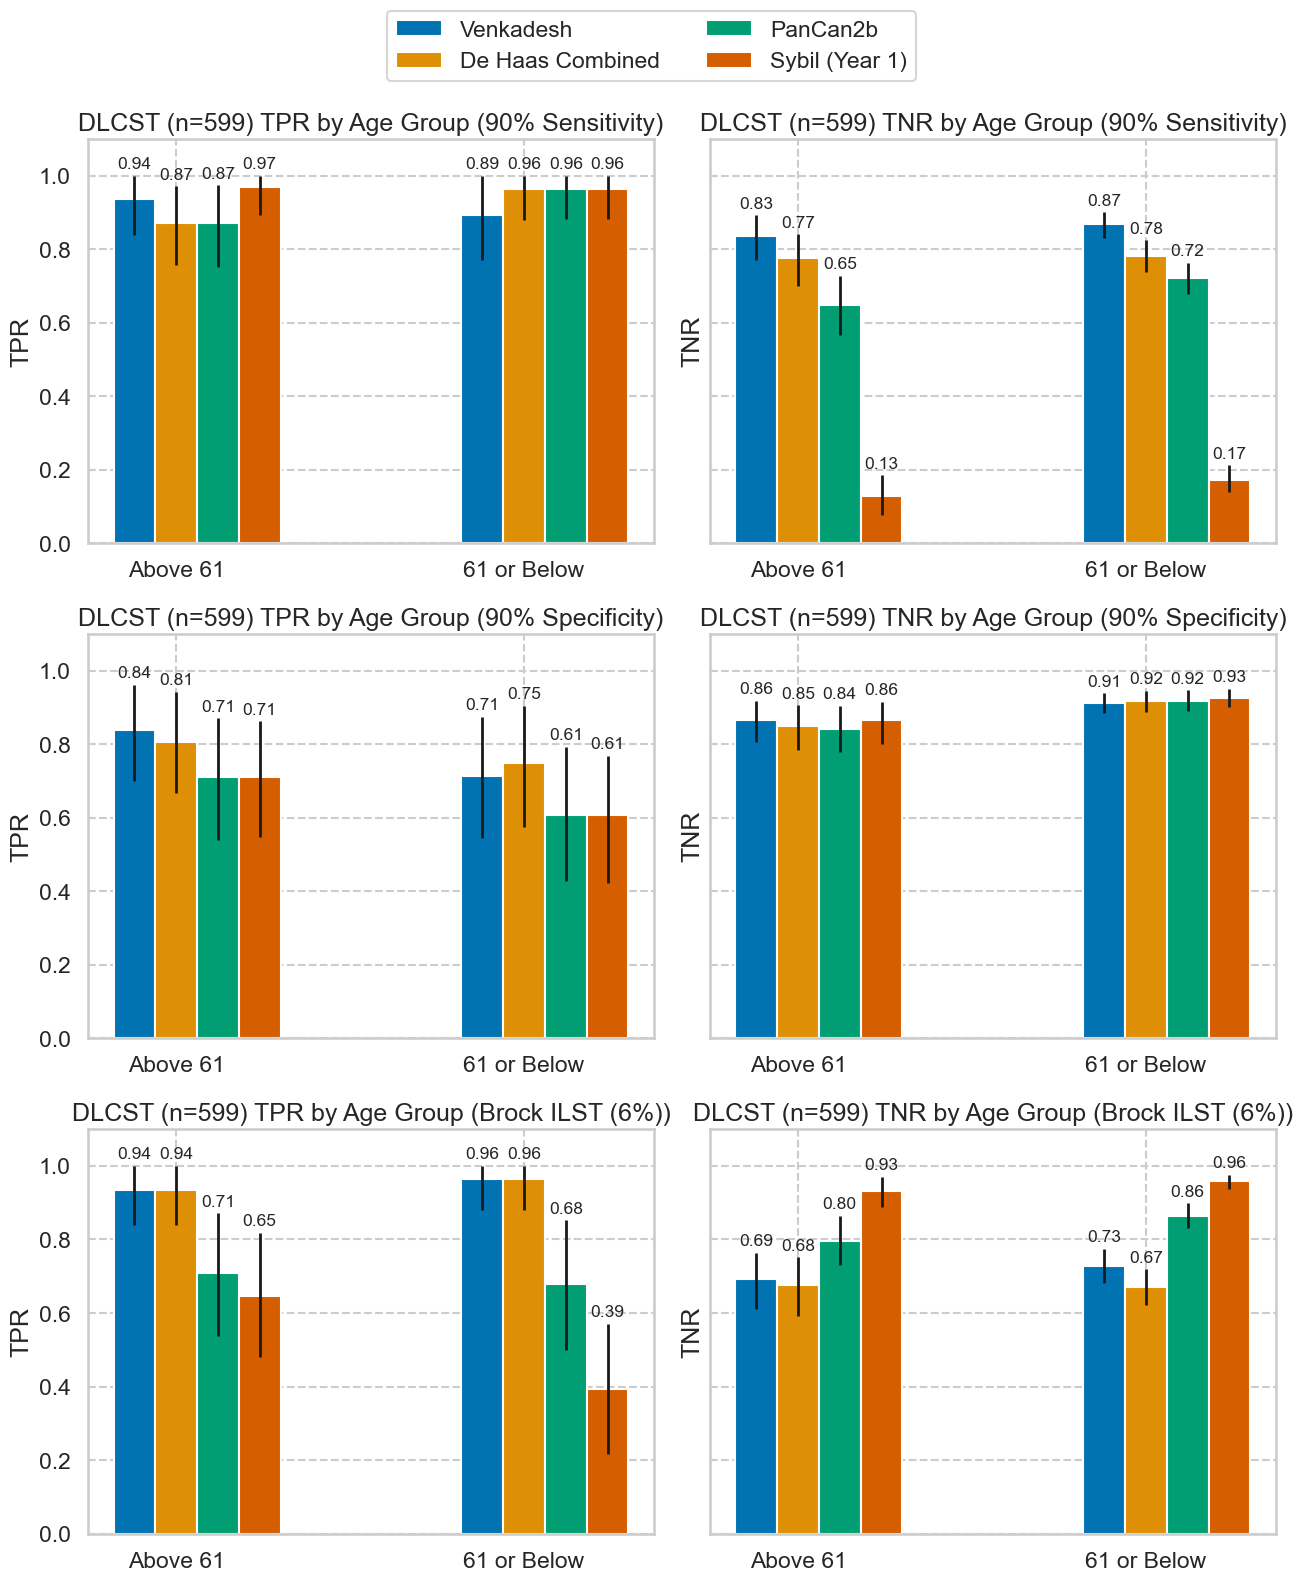

In [43]:
_ = threshold.plot_threshold_stats_subgroups(dlcst_preds_pretty, 'Age Group', dataset_name='DLCST',
                                             policies=dlcst_policies, models=DLCST_MODELCOLS, 
                                             stats=threshold_dlcst.query('attribute == "Age Group"'),
                                             plot_metrics=['TPR', 'TNR'], diff=False, show_mb_count=False,
                                             imgpath=f"{FIG_DIR}/thresholdDLCSTage.png"
                                            )

### NLST (1172)

In [44]:
threshold_nlst_1172 = pd.read_csv(f'{RESULTS_DIR}/threshold-perfs-nlst-1172.csv', index_col=0)
threshold_nlst_1172, nlst_1172_policies = threshold_stats_pretty(threshold_nlst_1172, nlst_1172_policies)
# display(nlst_1172_policies)
# display(threshold_nlst_1172[['category', 'attribute', 'group', 'policy', 'model', 'FPR', 'FPR_lo', 'FPR_hi']])
# NLST_1172_MODELCOLS

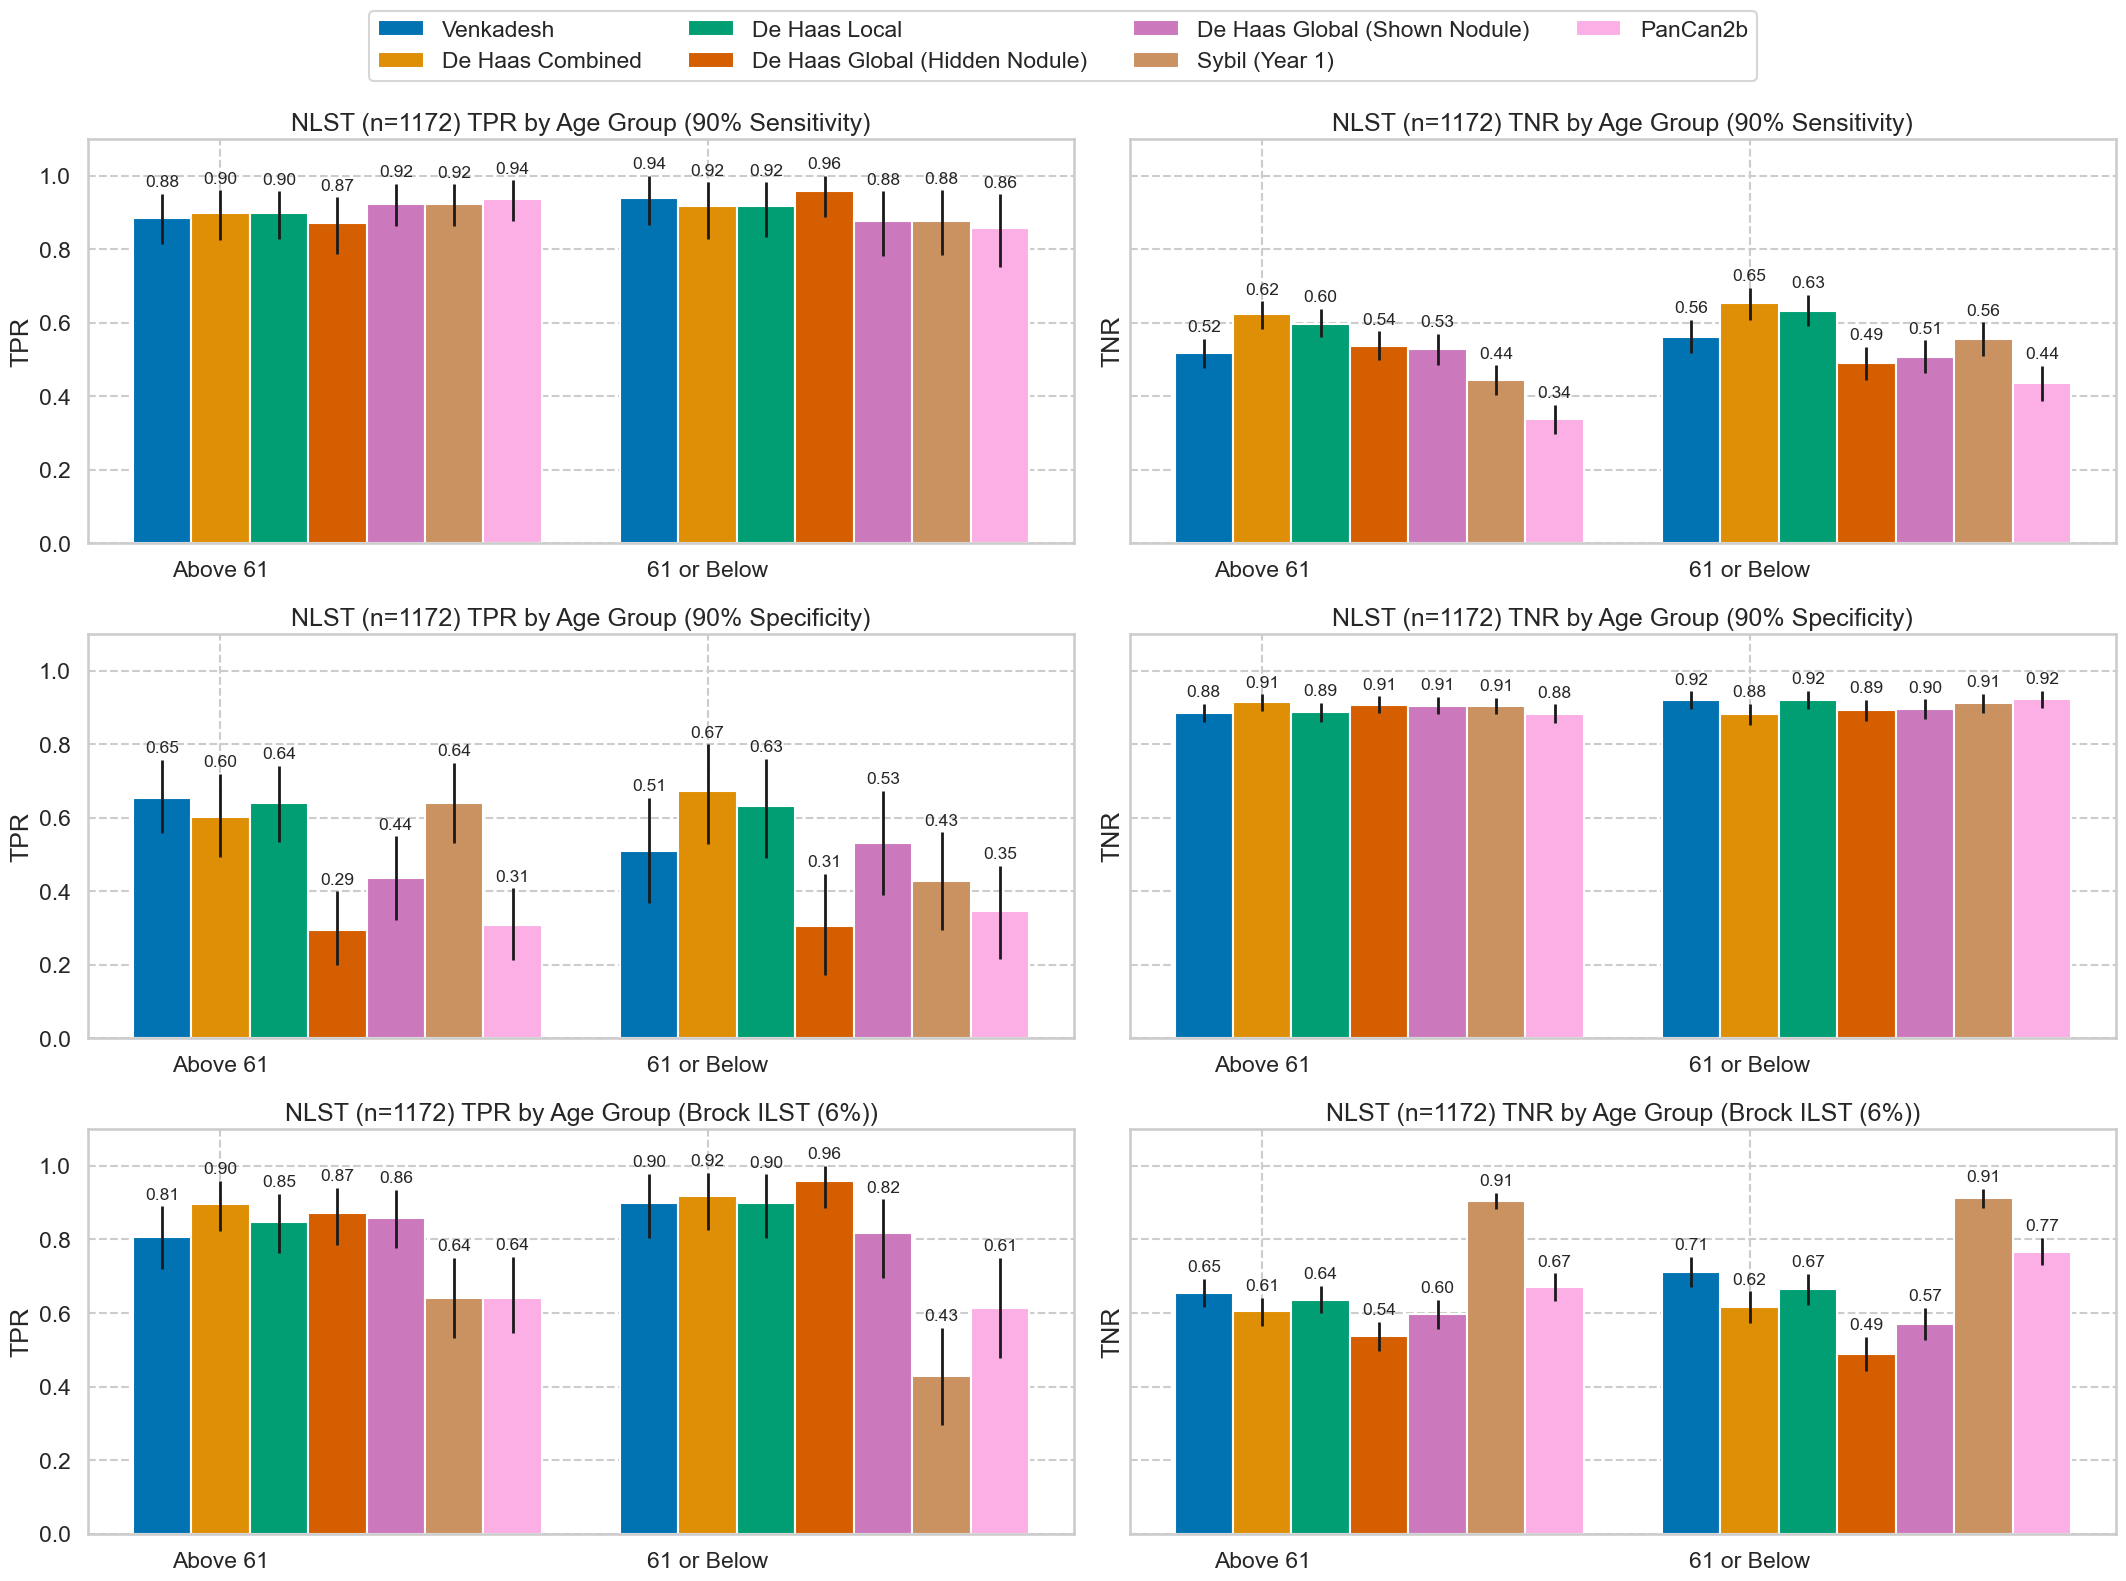

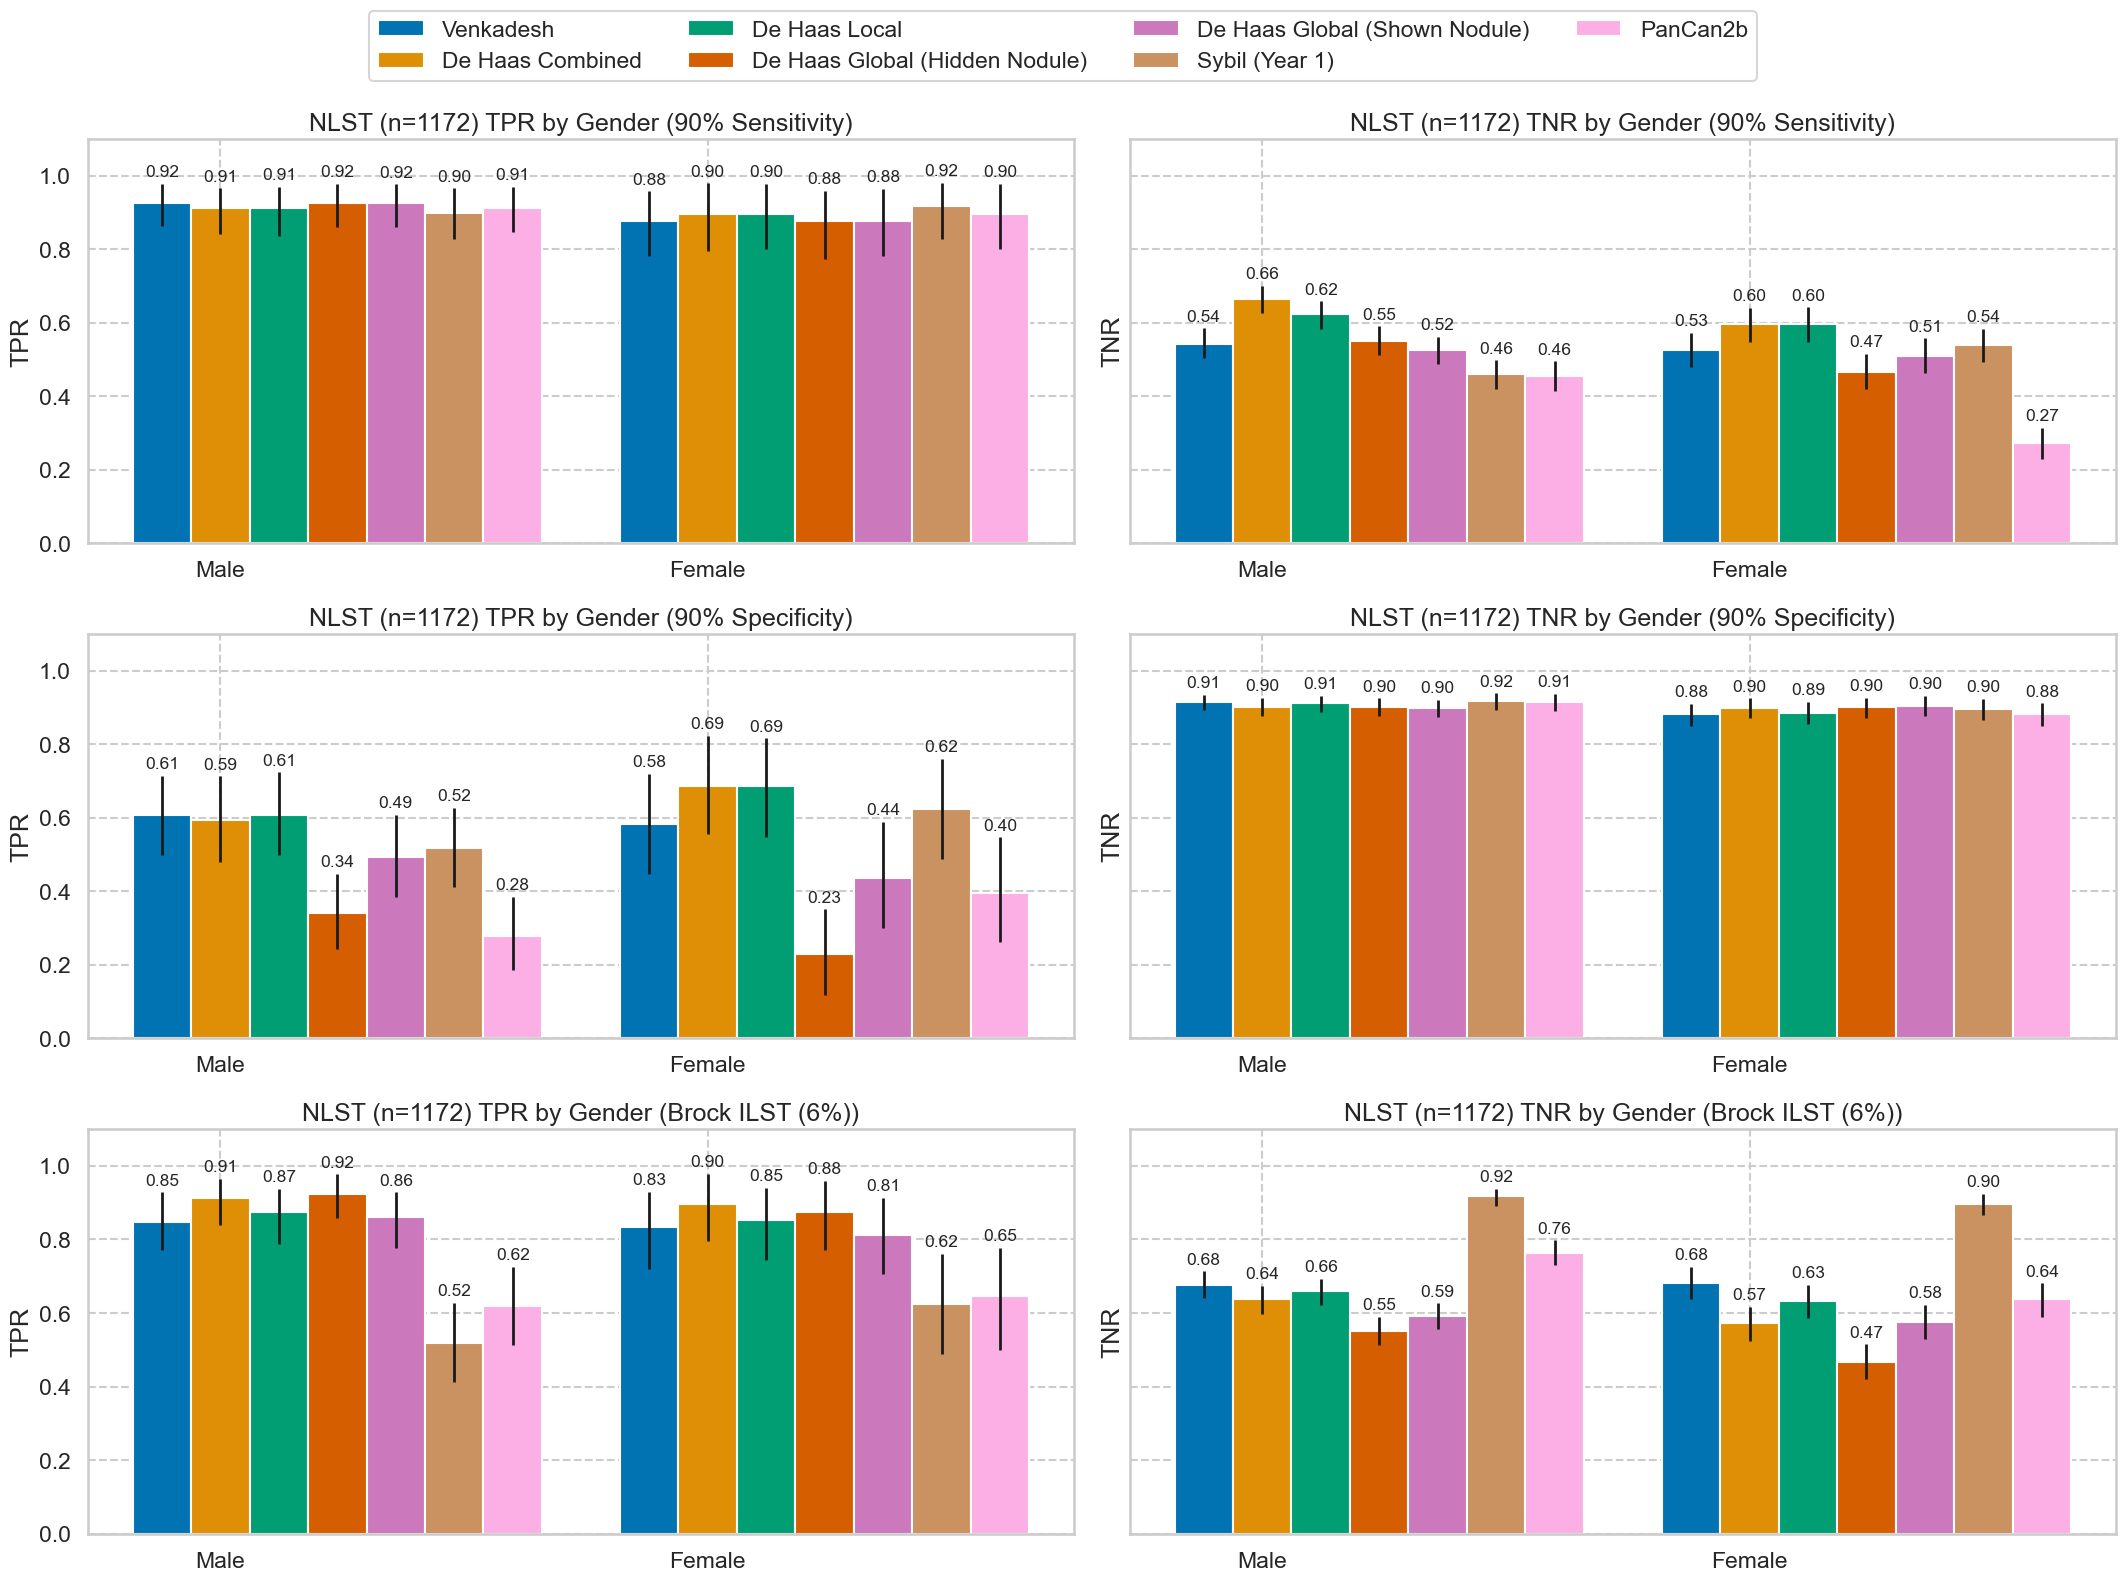

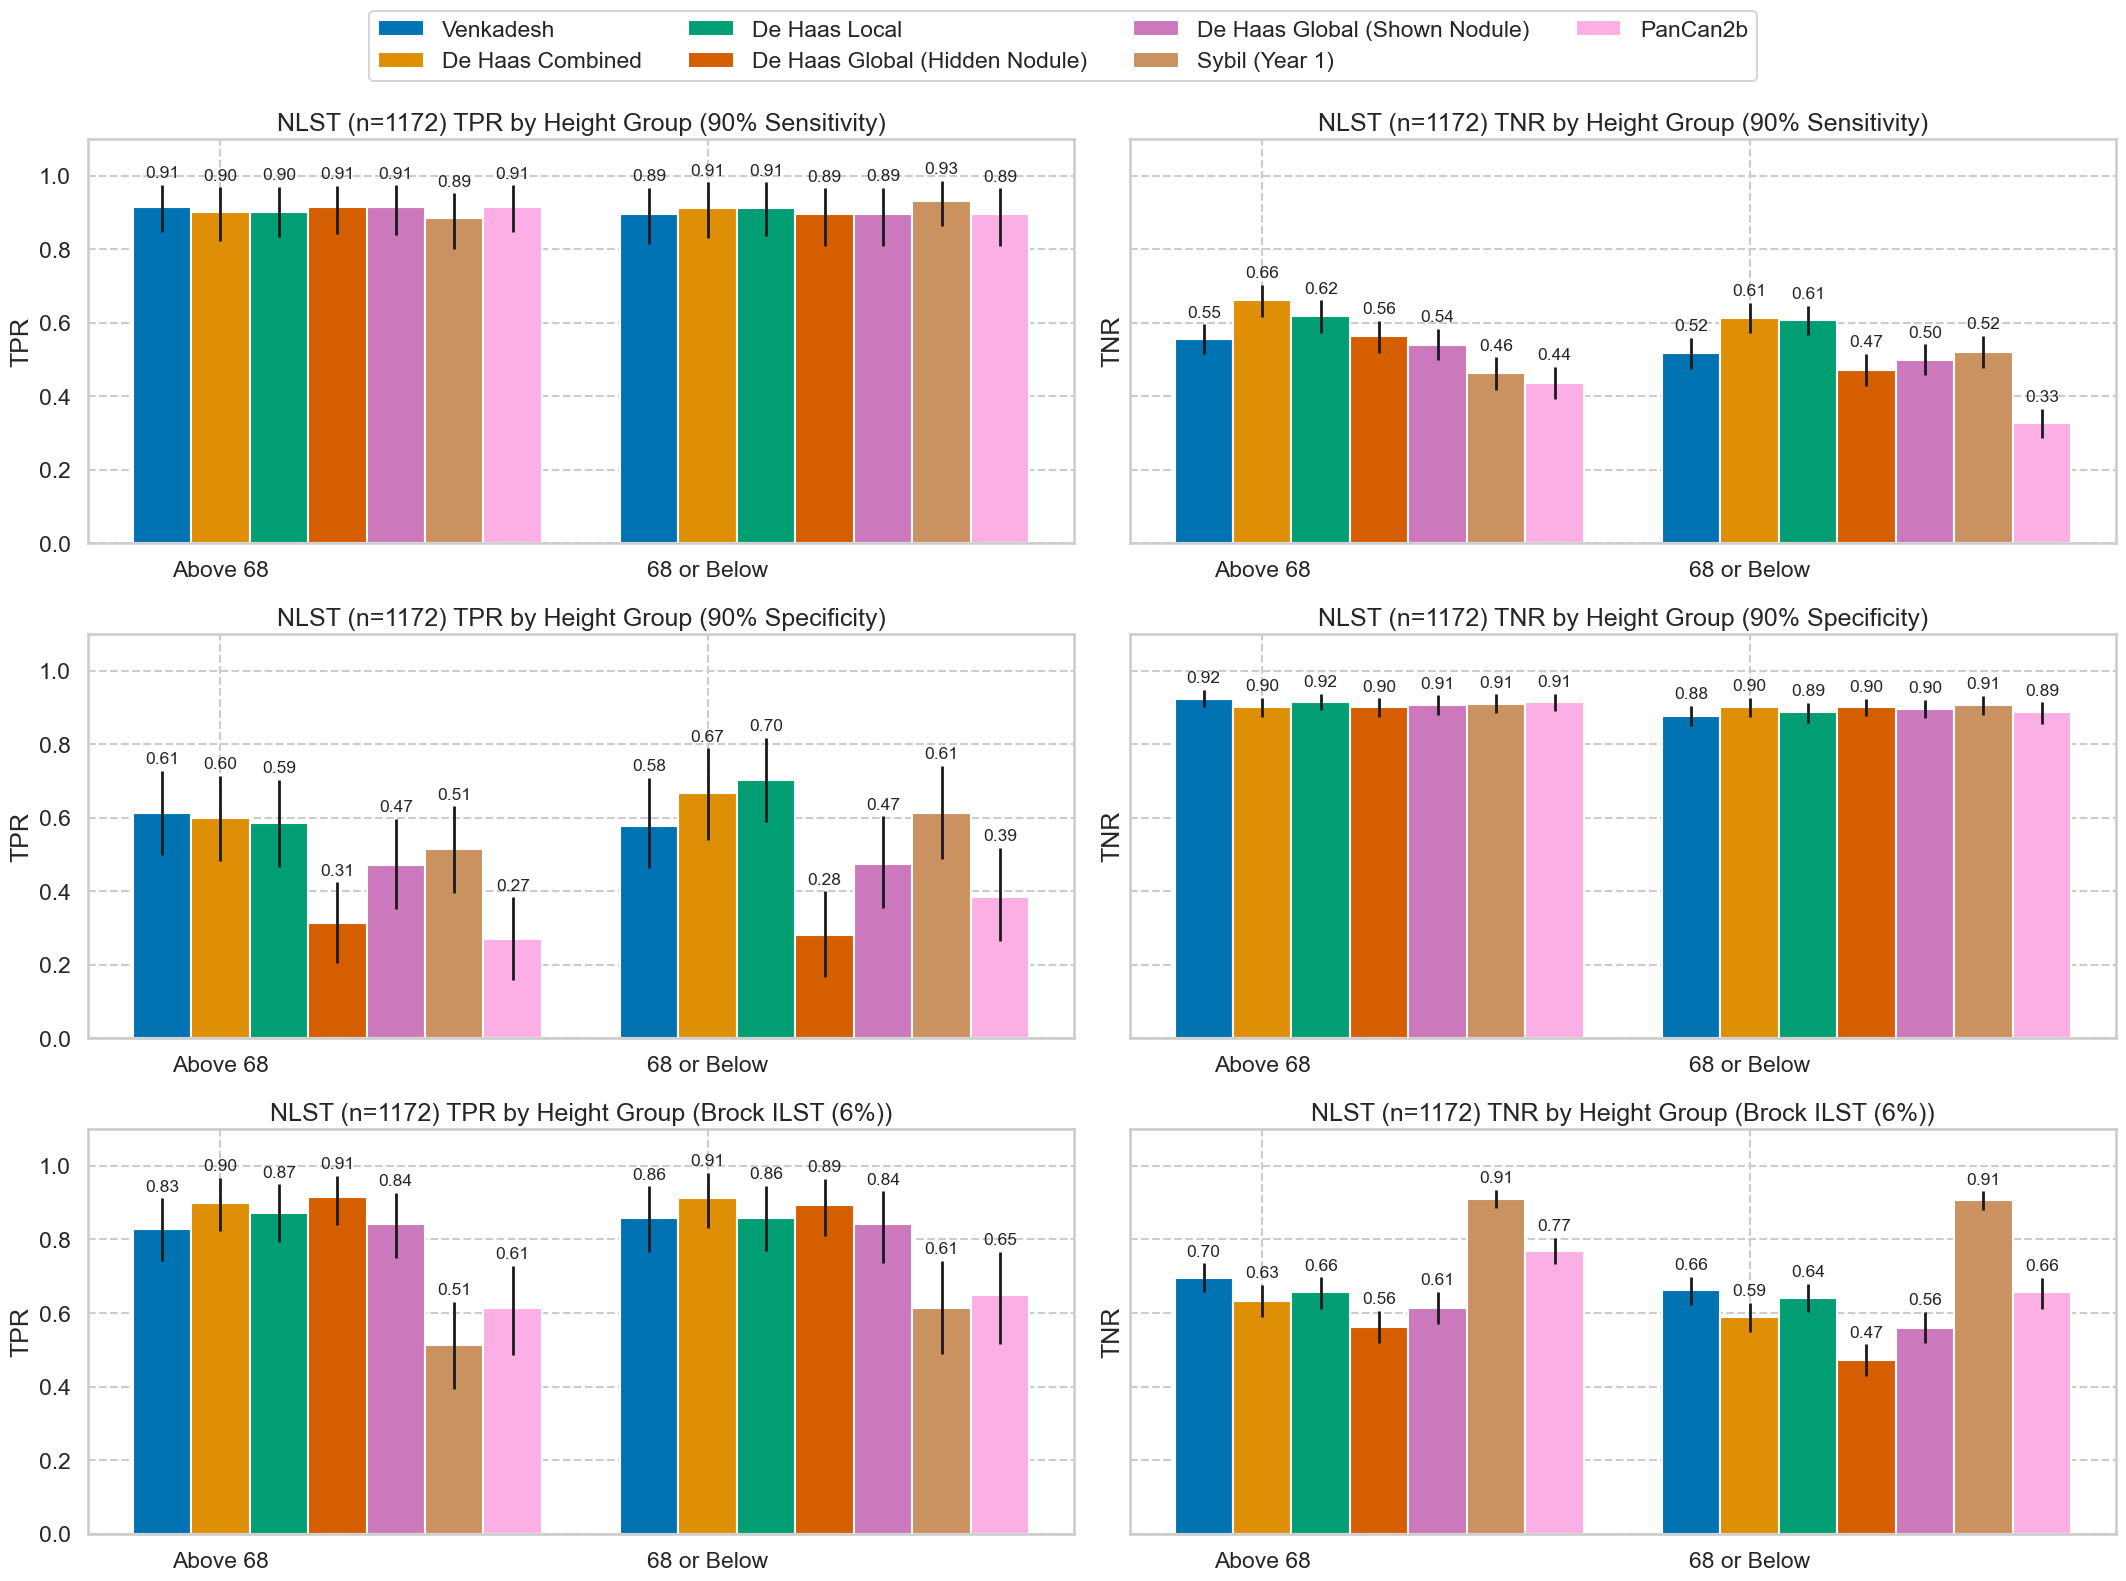

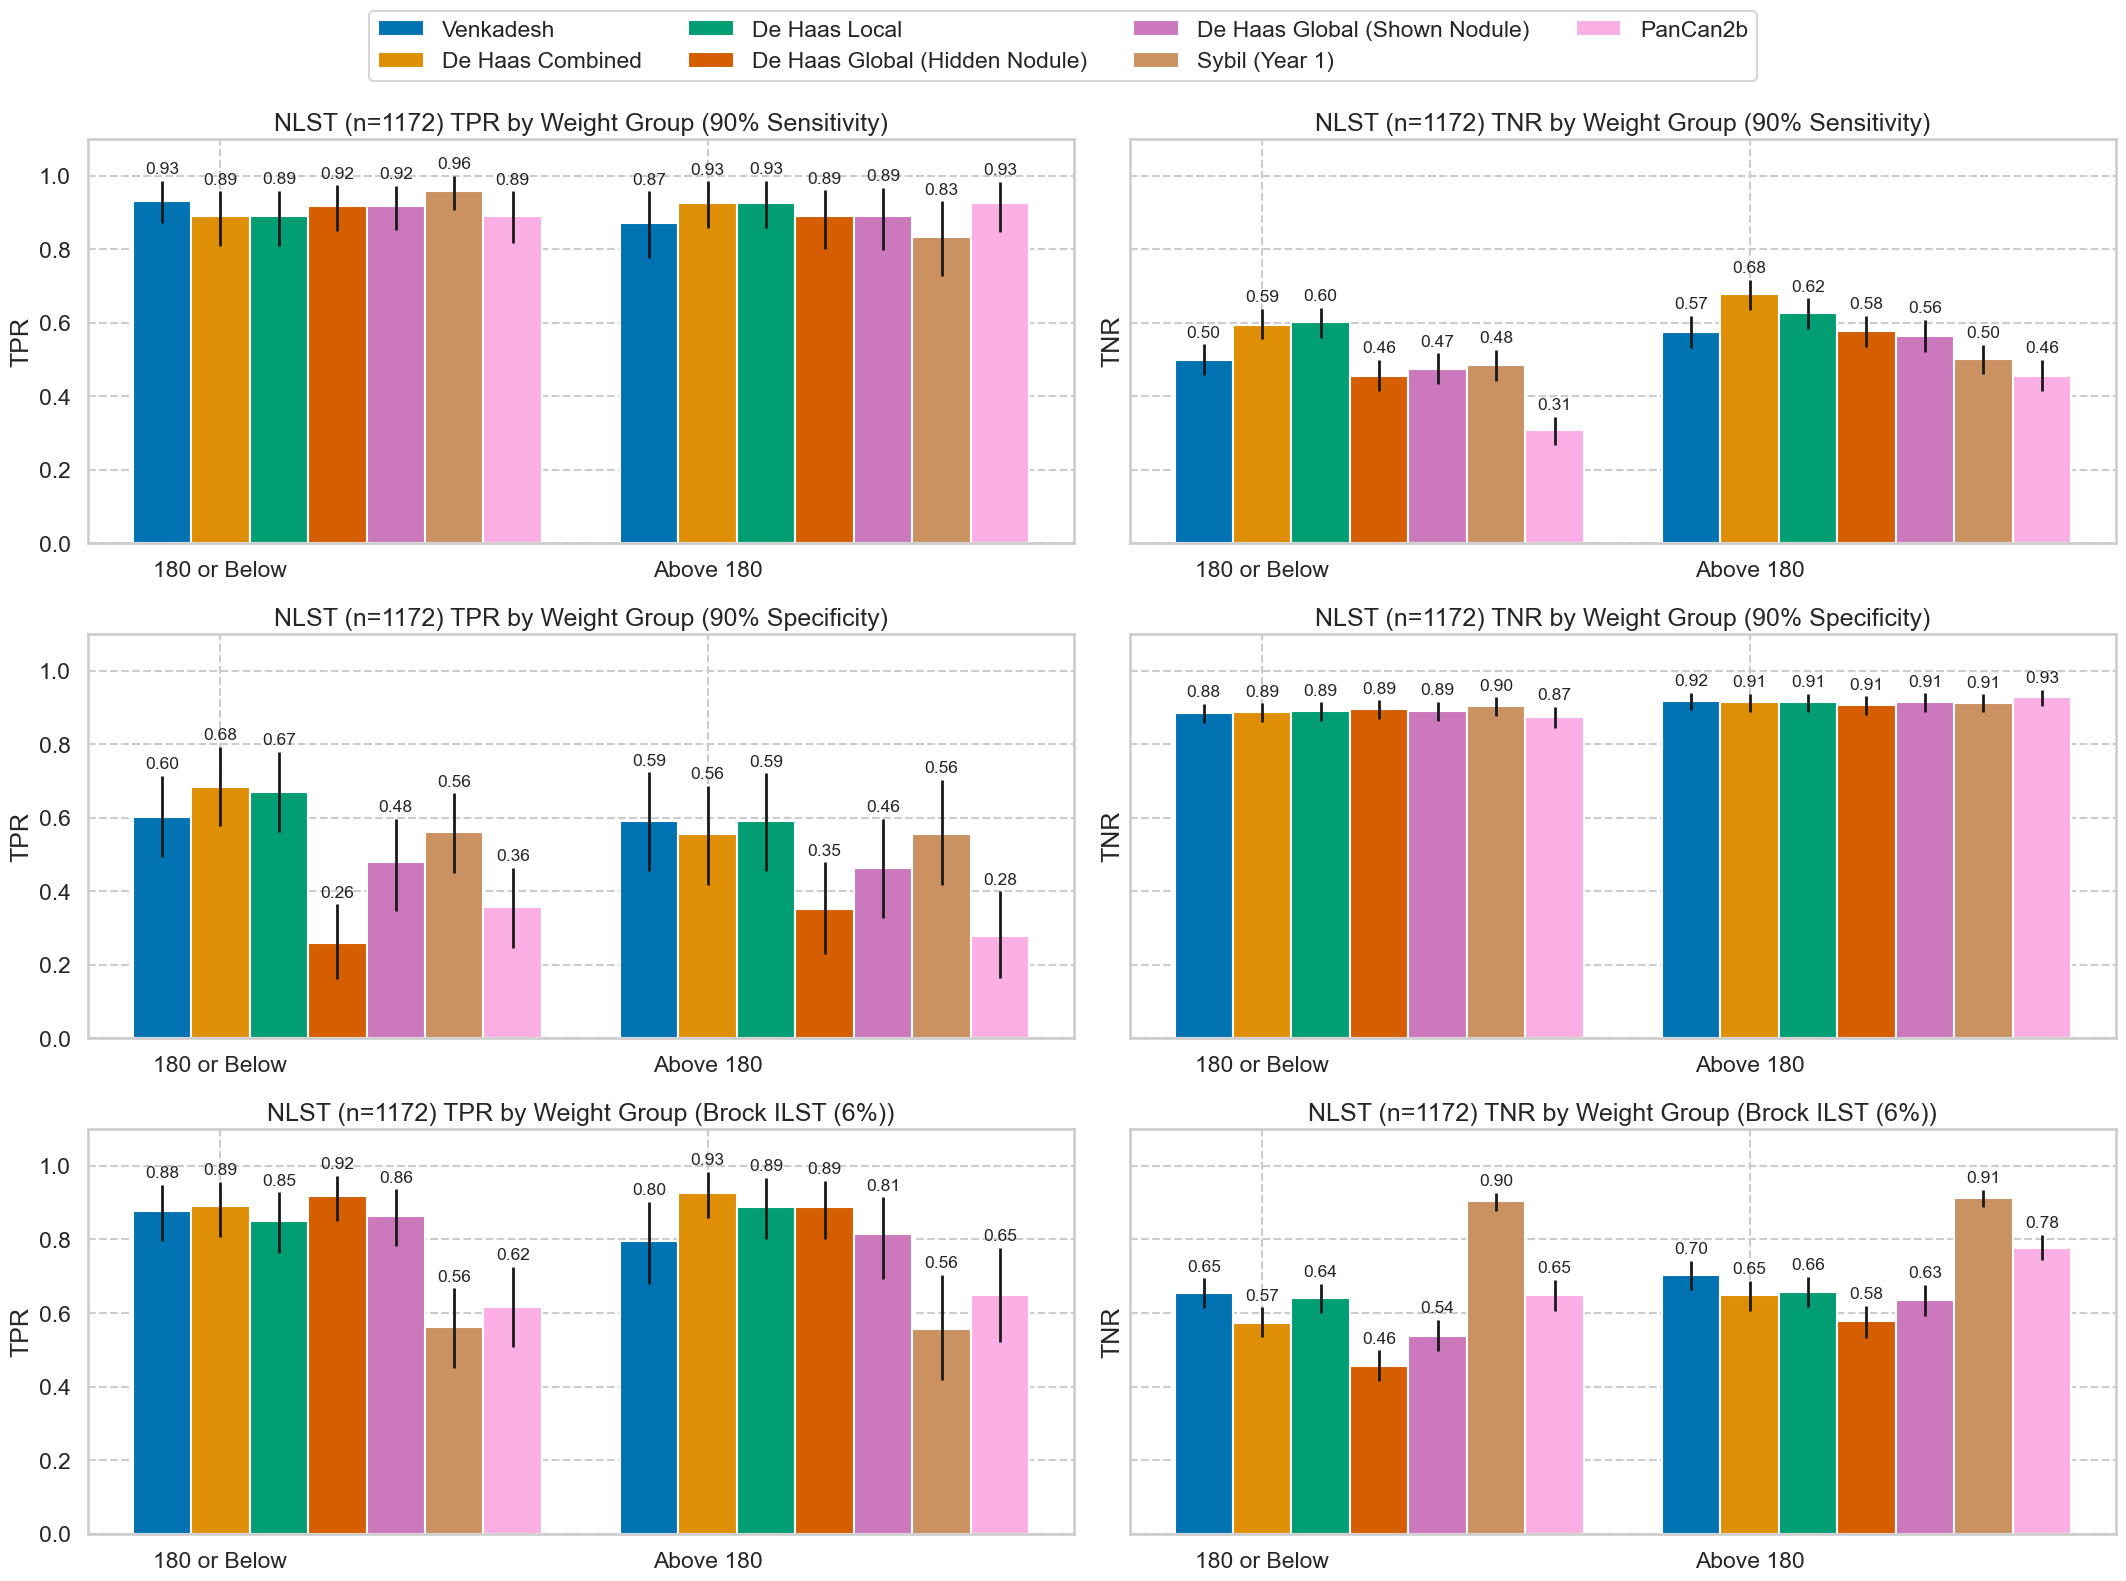

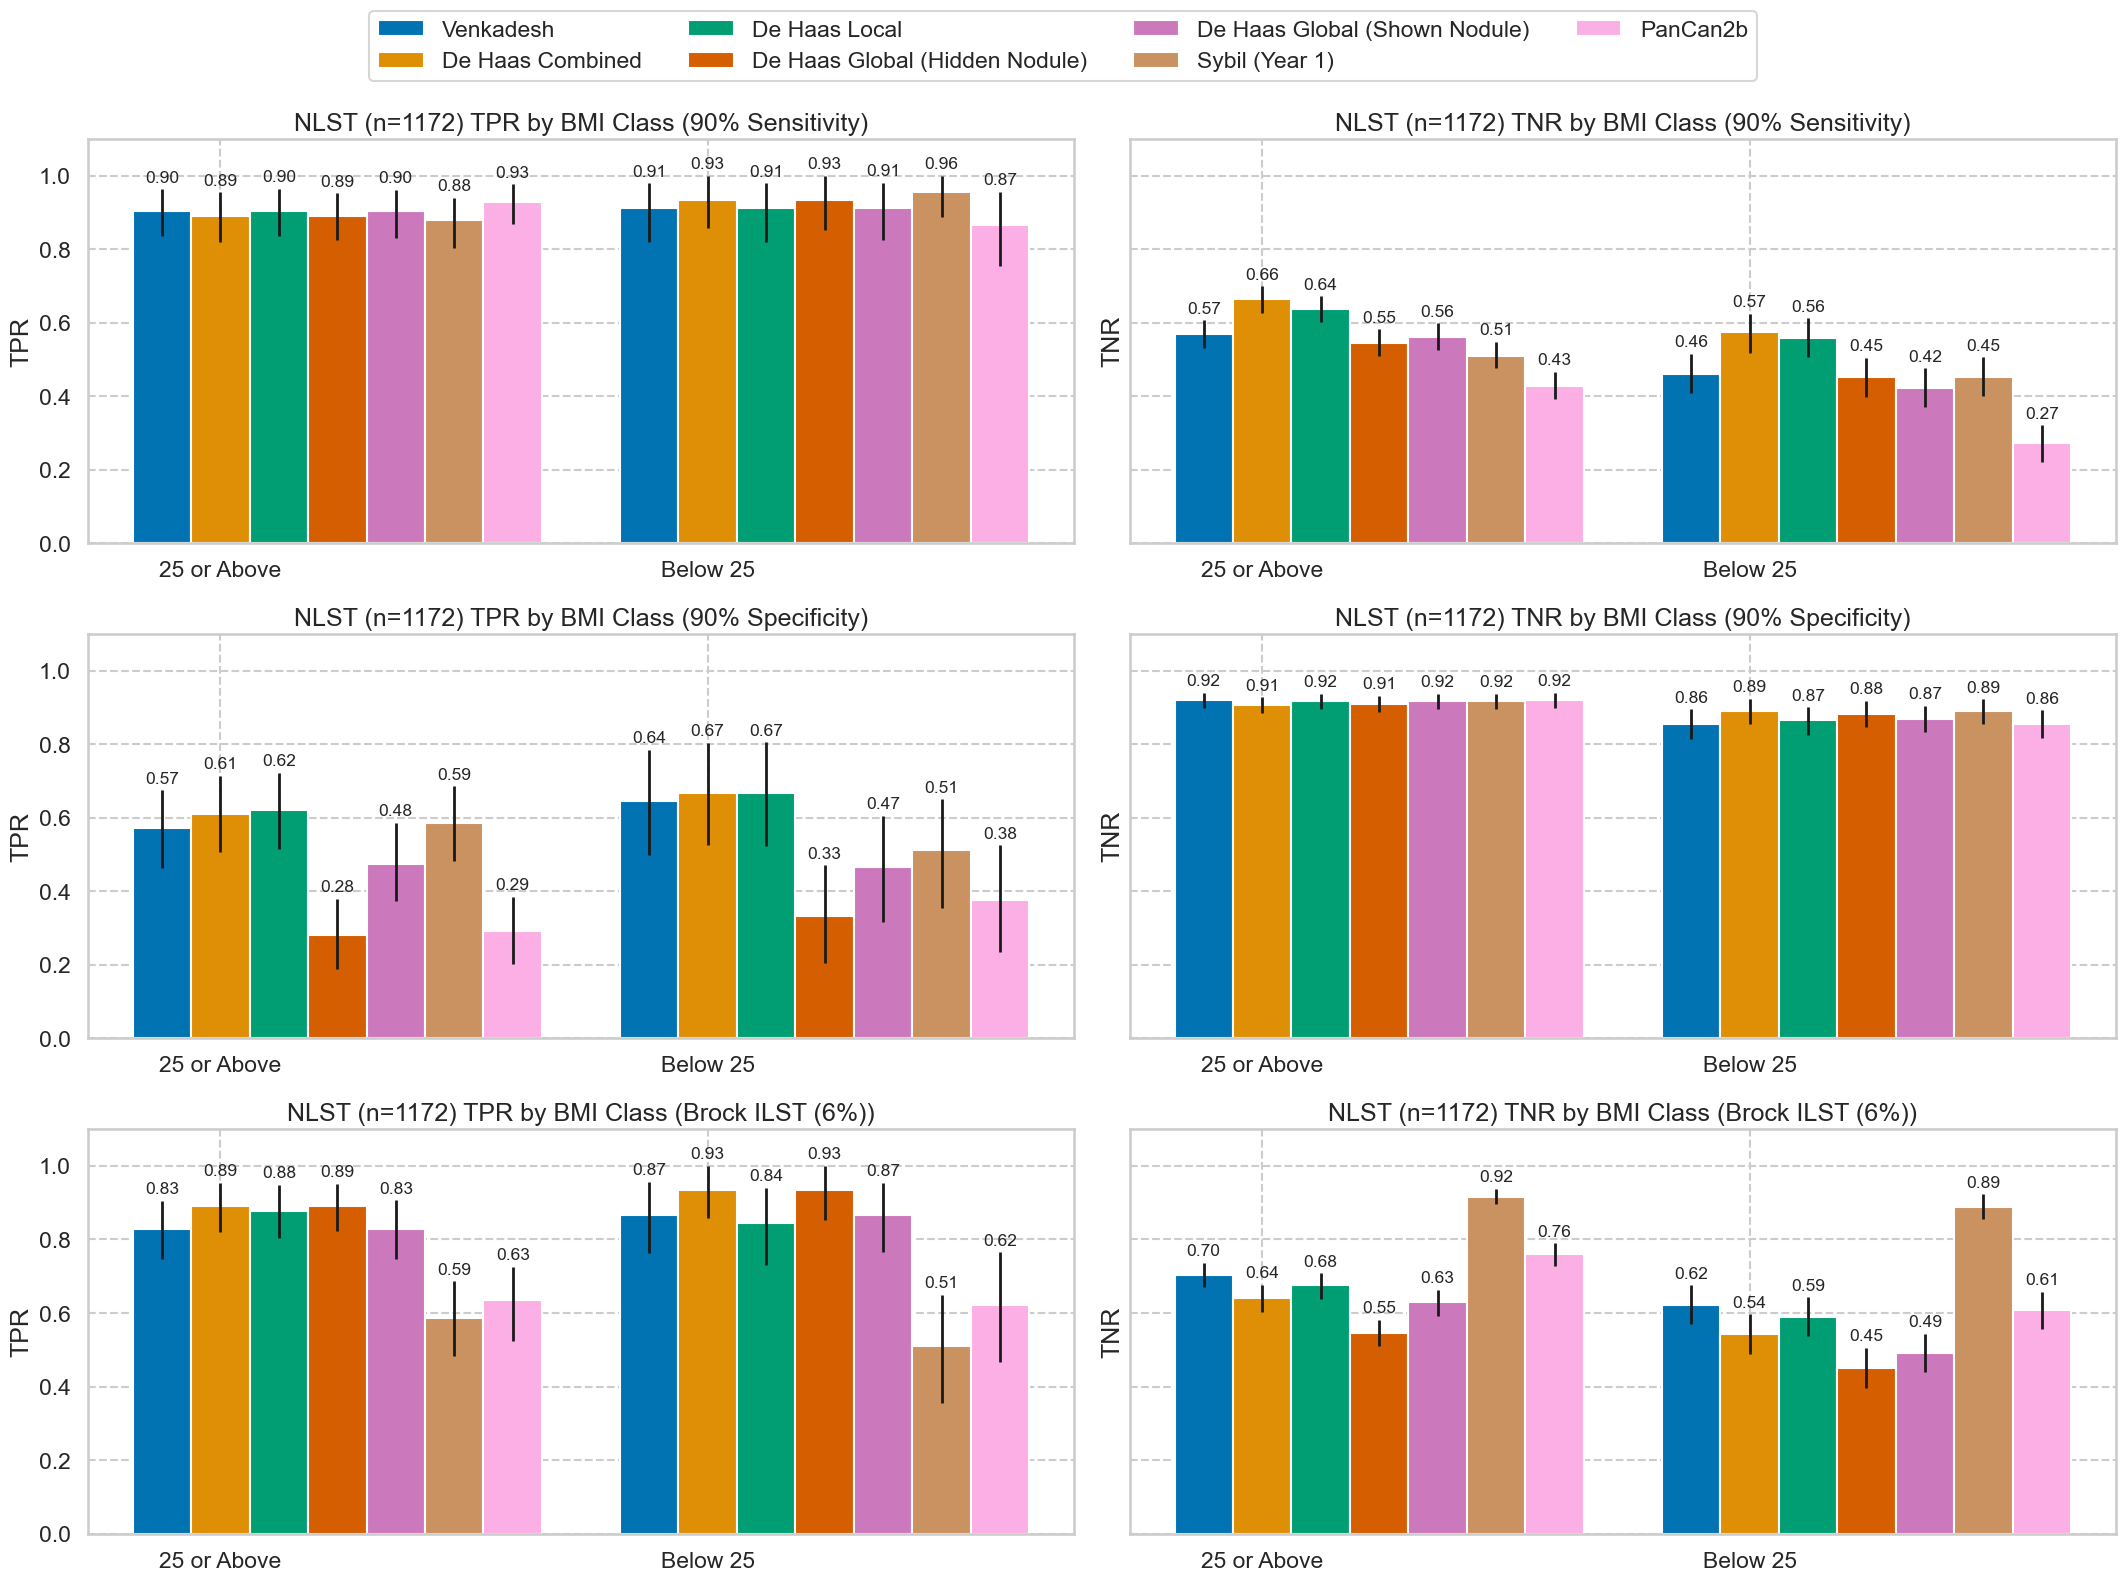

In [45]:
for col in nlst_demos_to_include:
    _ = threshold.plot_threshold_stats_subgroups(nlst_1172, col, dataset_name='NLST',
                                                policies=nlst_1172_policies, models=NLST_1172_MODELCOLS, 
                                                stats=threshold_nlst_1172.query(f'attribute == "{col}"'),
                                                plot_metrics=['TPR', 'TNR'], diff=False, show_mb_count=False,
                                                imgpath=f"{FIG_DIR}/threshold-NLST-1172/{col}.png"
                                                )  

### NLST 5911


In [46]:
threshold_nlst_5911 = pd.read_csv(f'{RESULTS_DIR}/threshold-perfs-nlst-5911.csv', index_col=0)
threshold_nlst_5911, nlst_5911_policies = threshold_stats_pretty(threshold_nlst_5911, nlst_5911_policies)
# display(nlst_5911_policies)
# display(threshold_nlst_5911[['category', 'attribute', 'group', 'policy', 'model', 'FPR', 'FPR_lo', 'FPR_hi']])
# NLST_5911_MODELCOLS

['Age Group', 'Gender', 'Race', 'HS Education', 'Height Group', 'Weight Group', 'BMI Class']


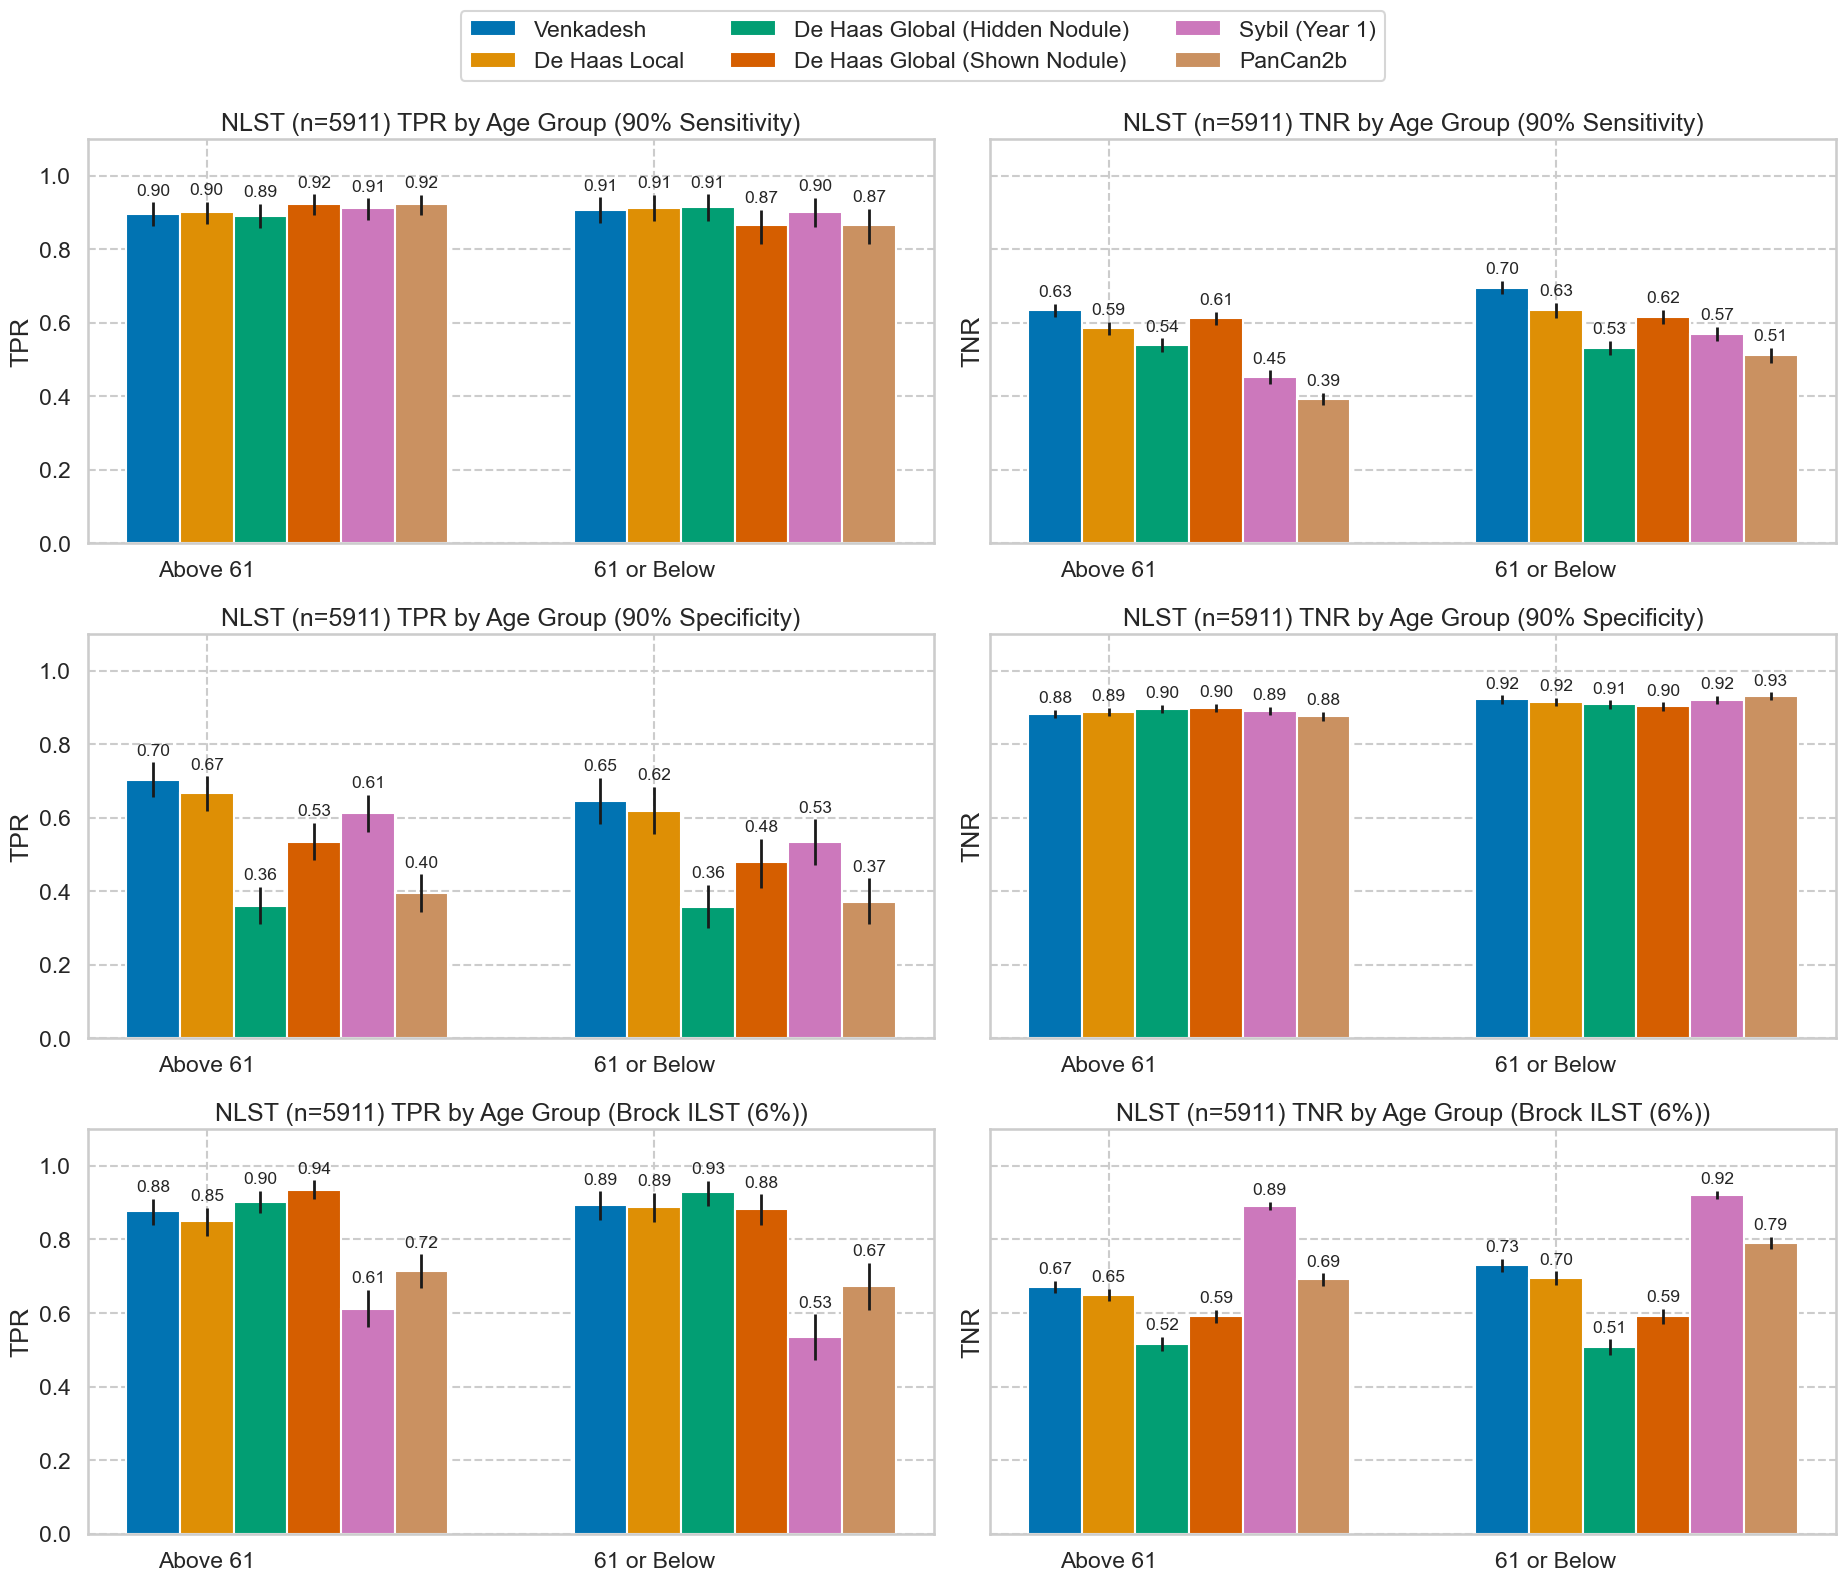

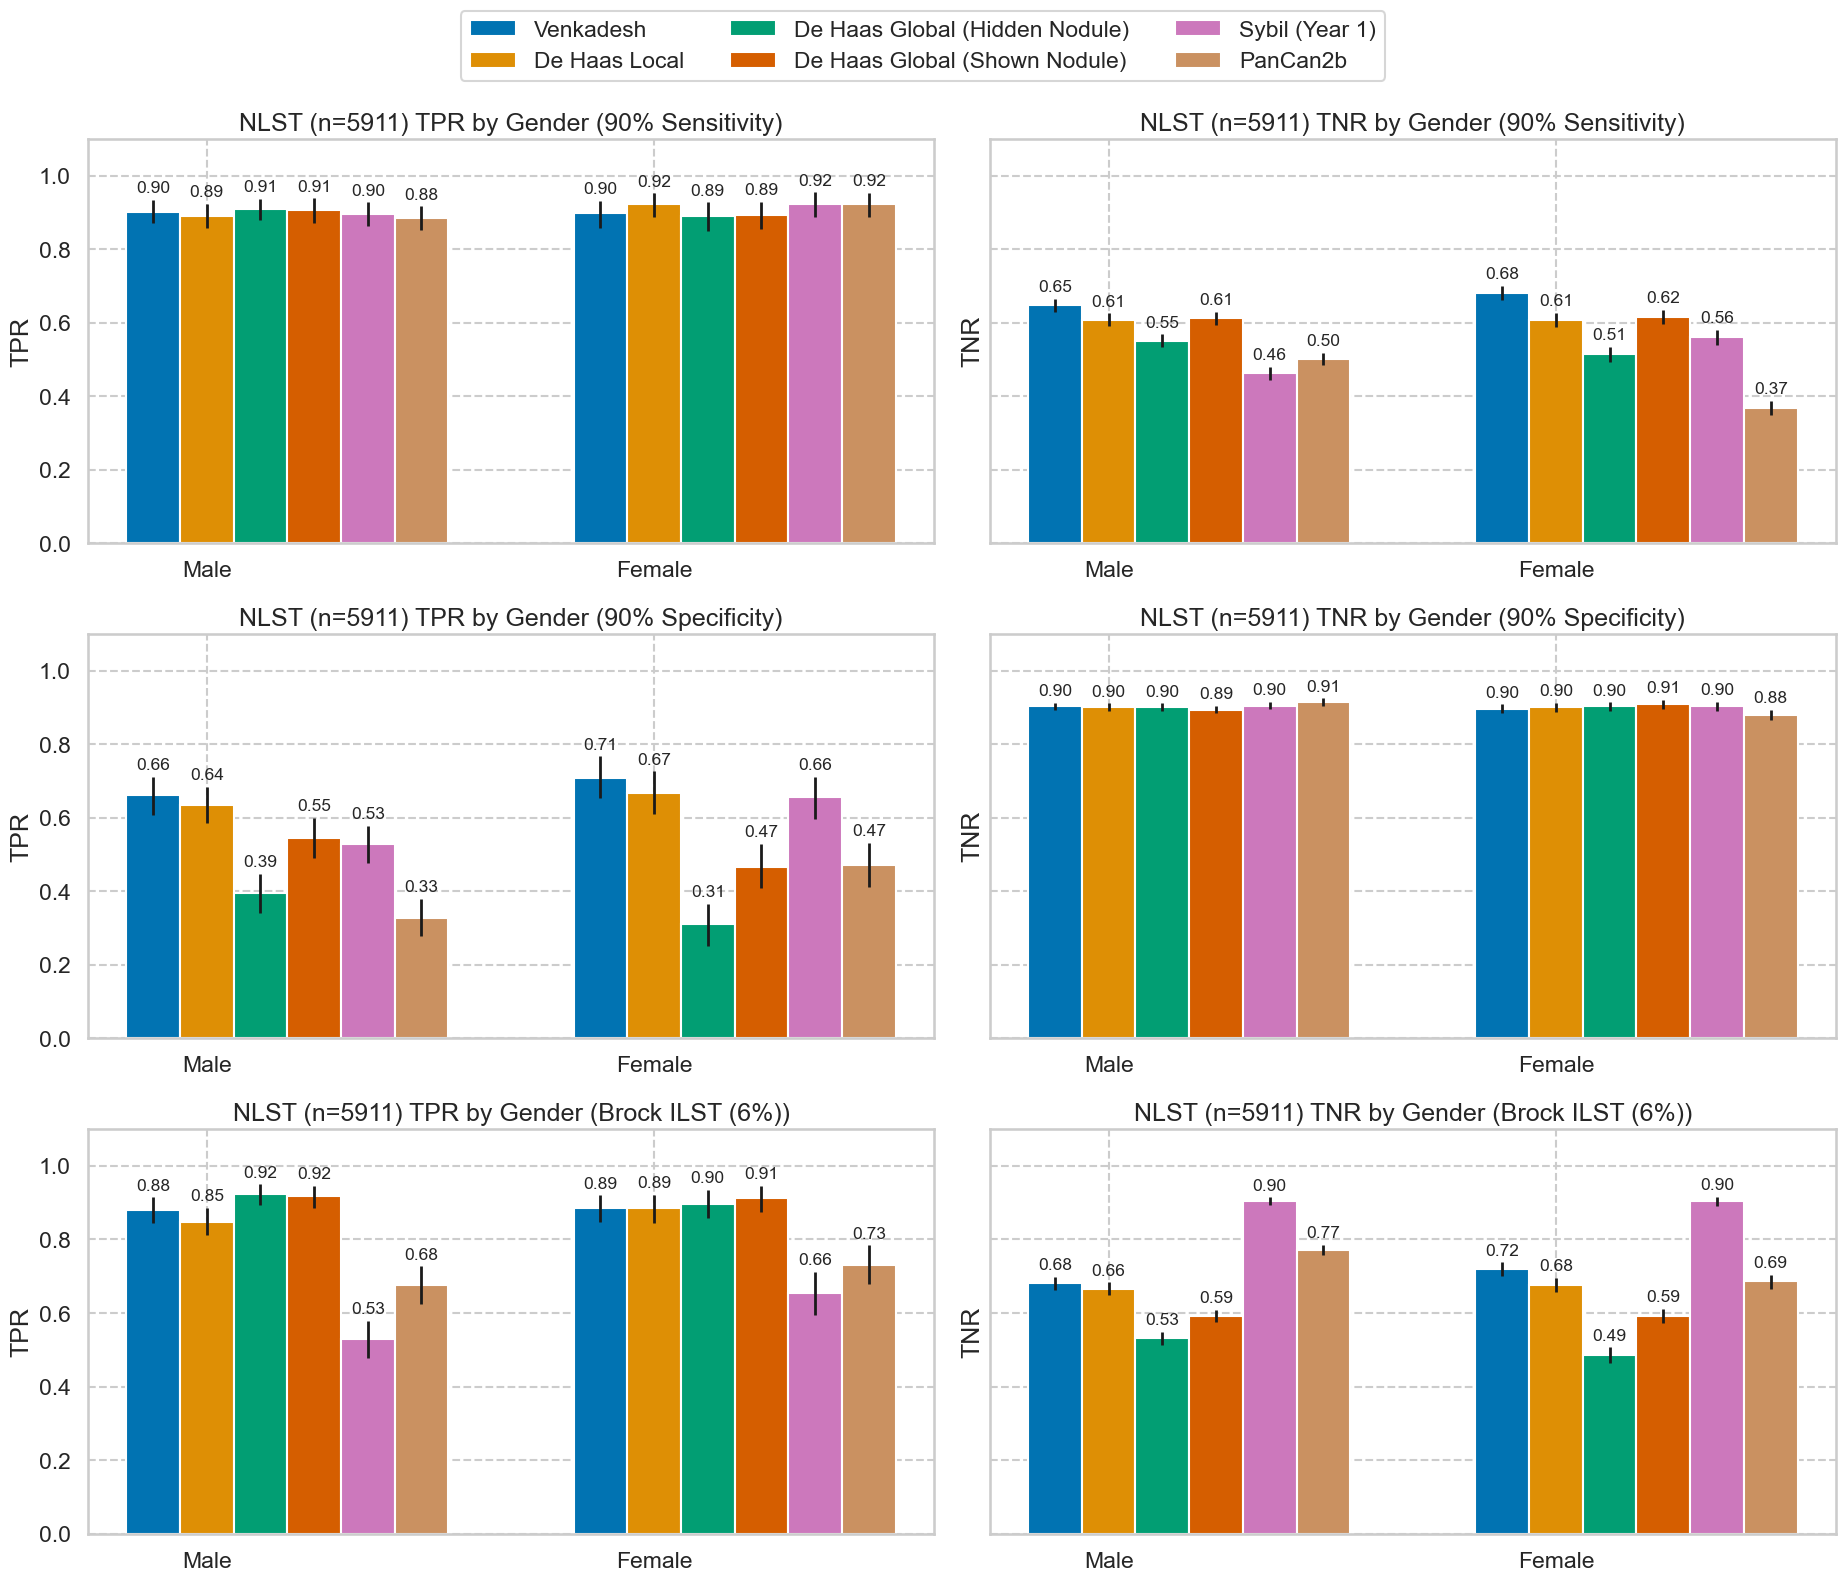

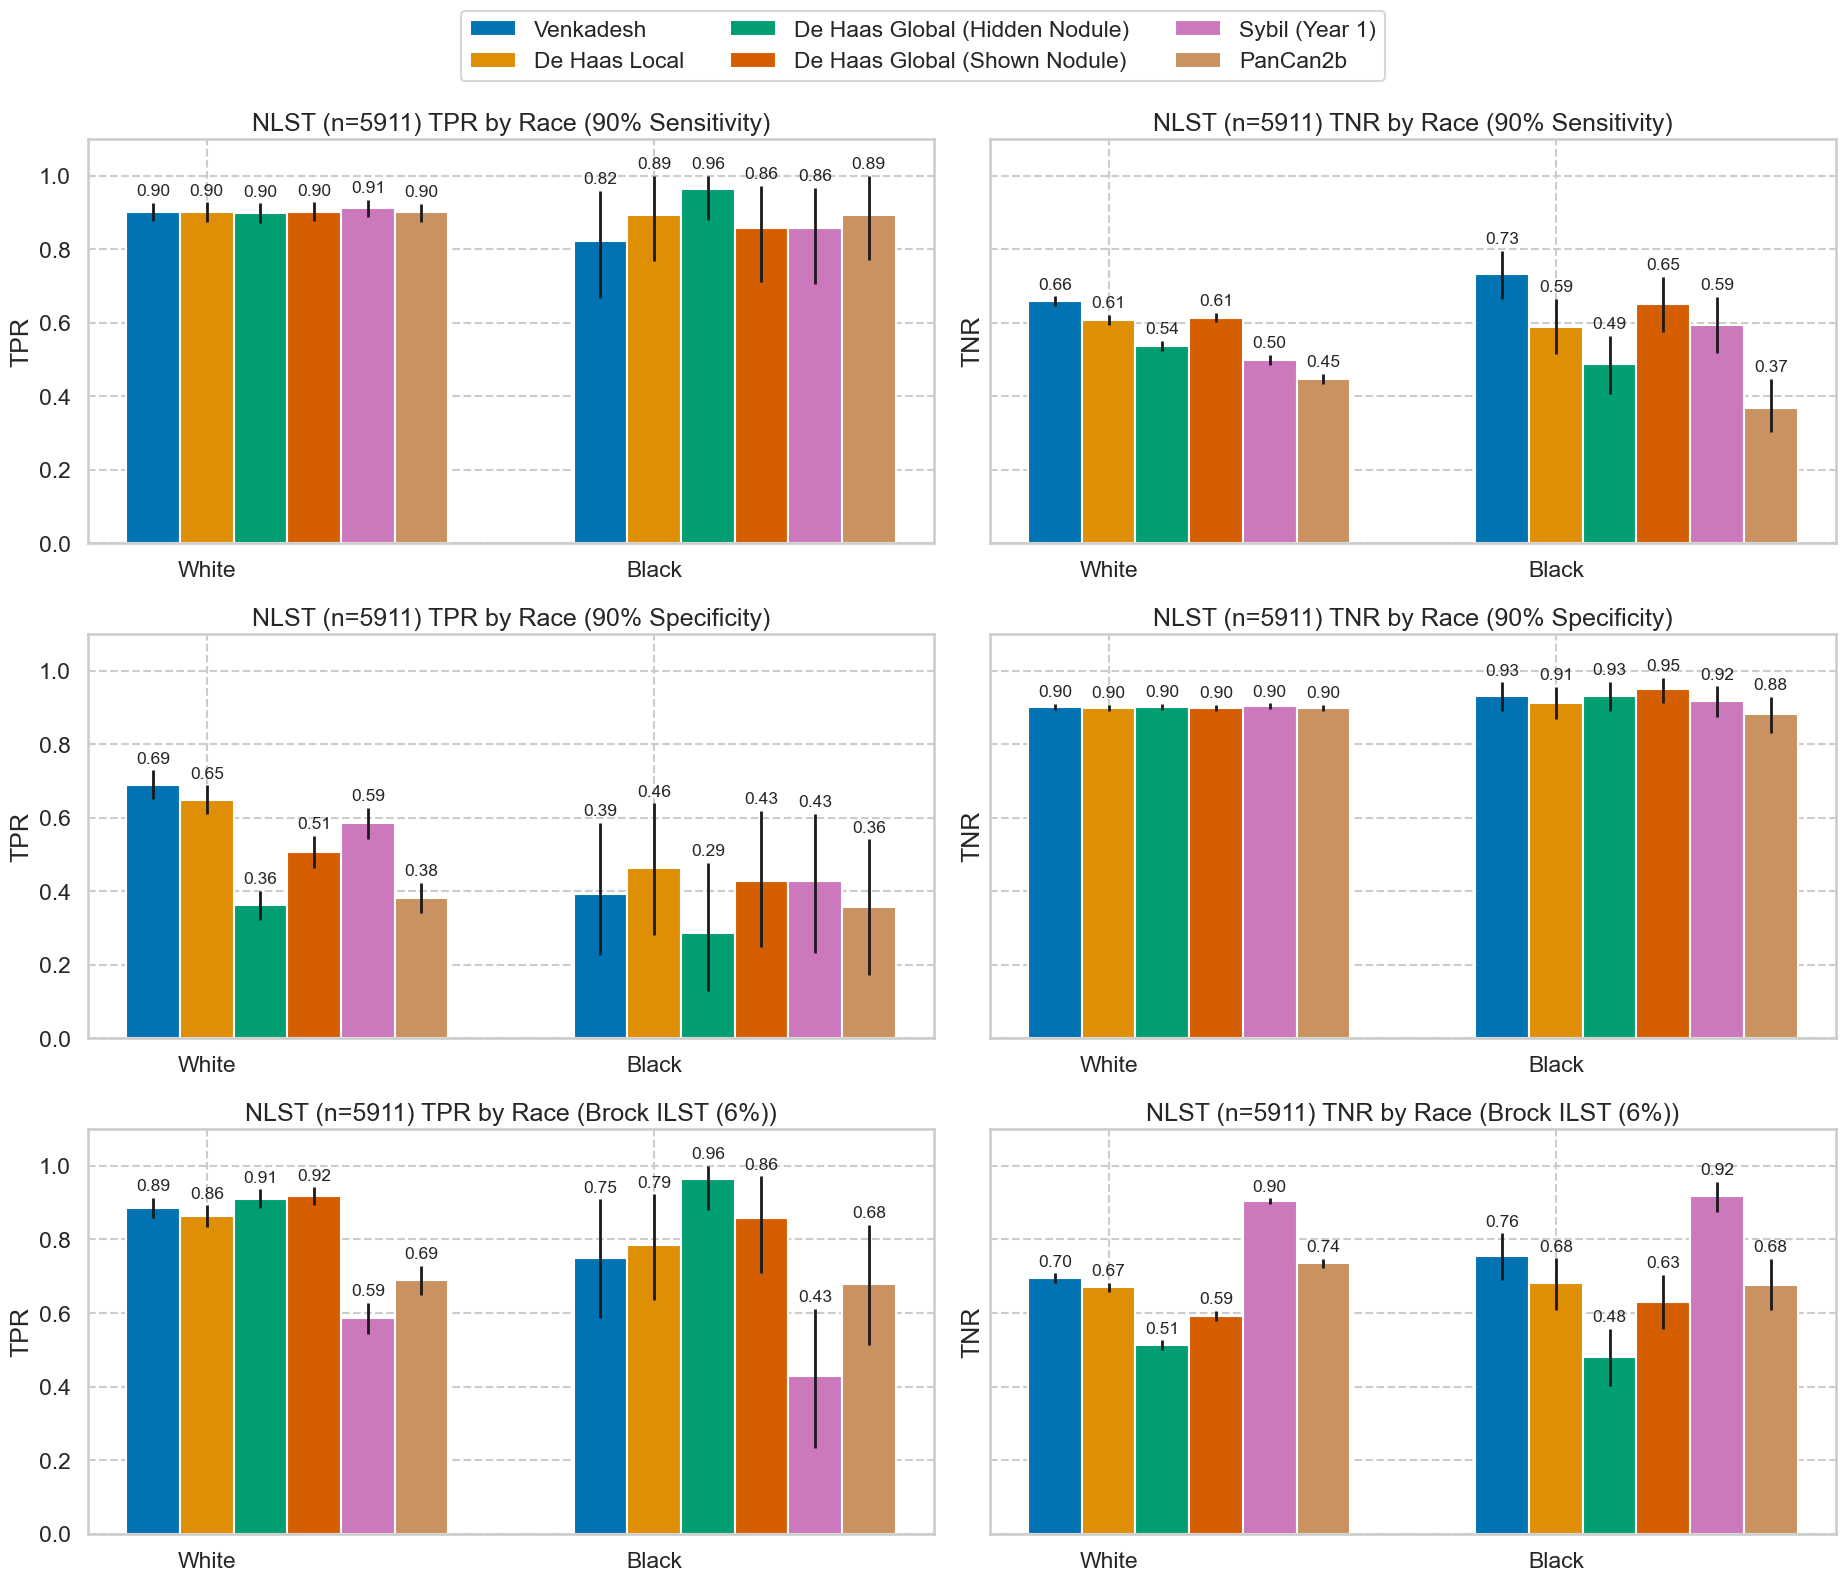

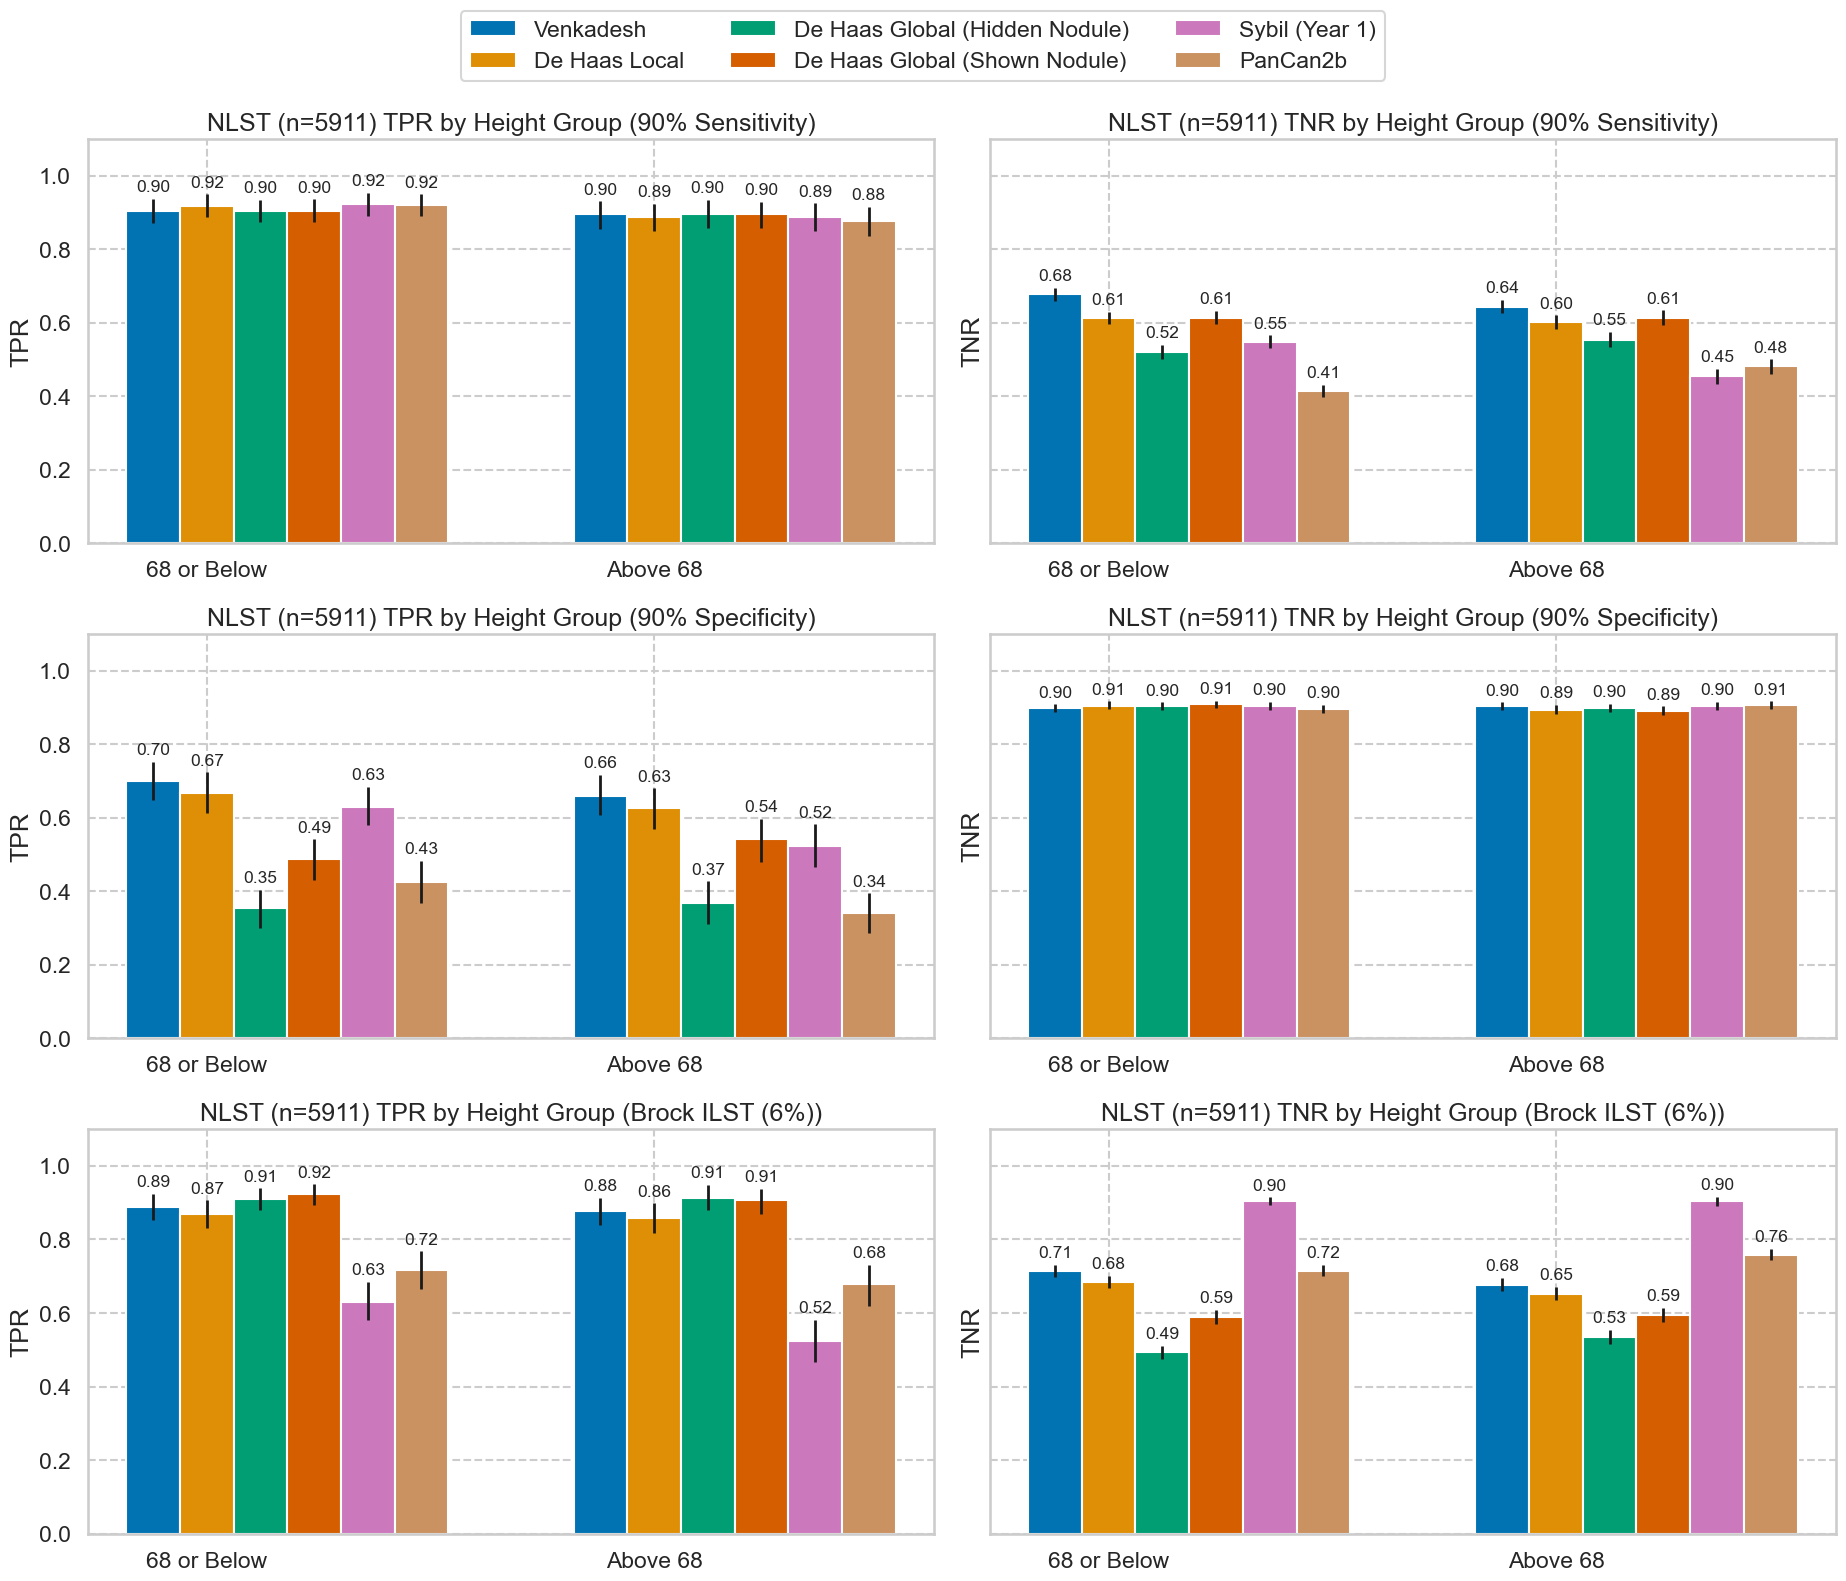

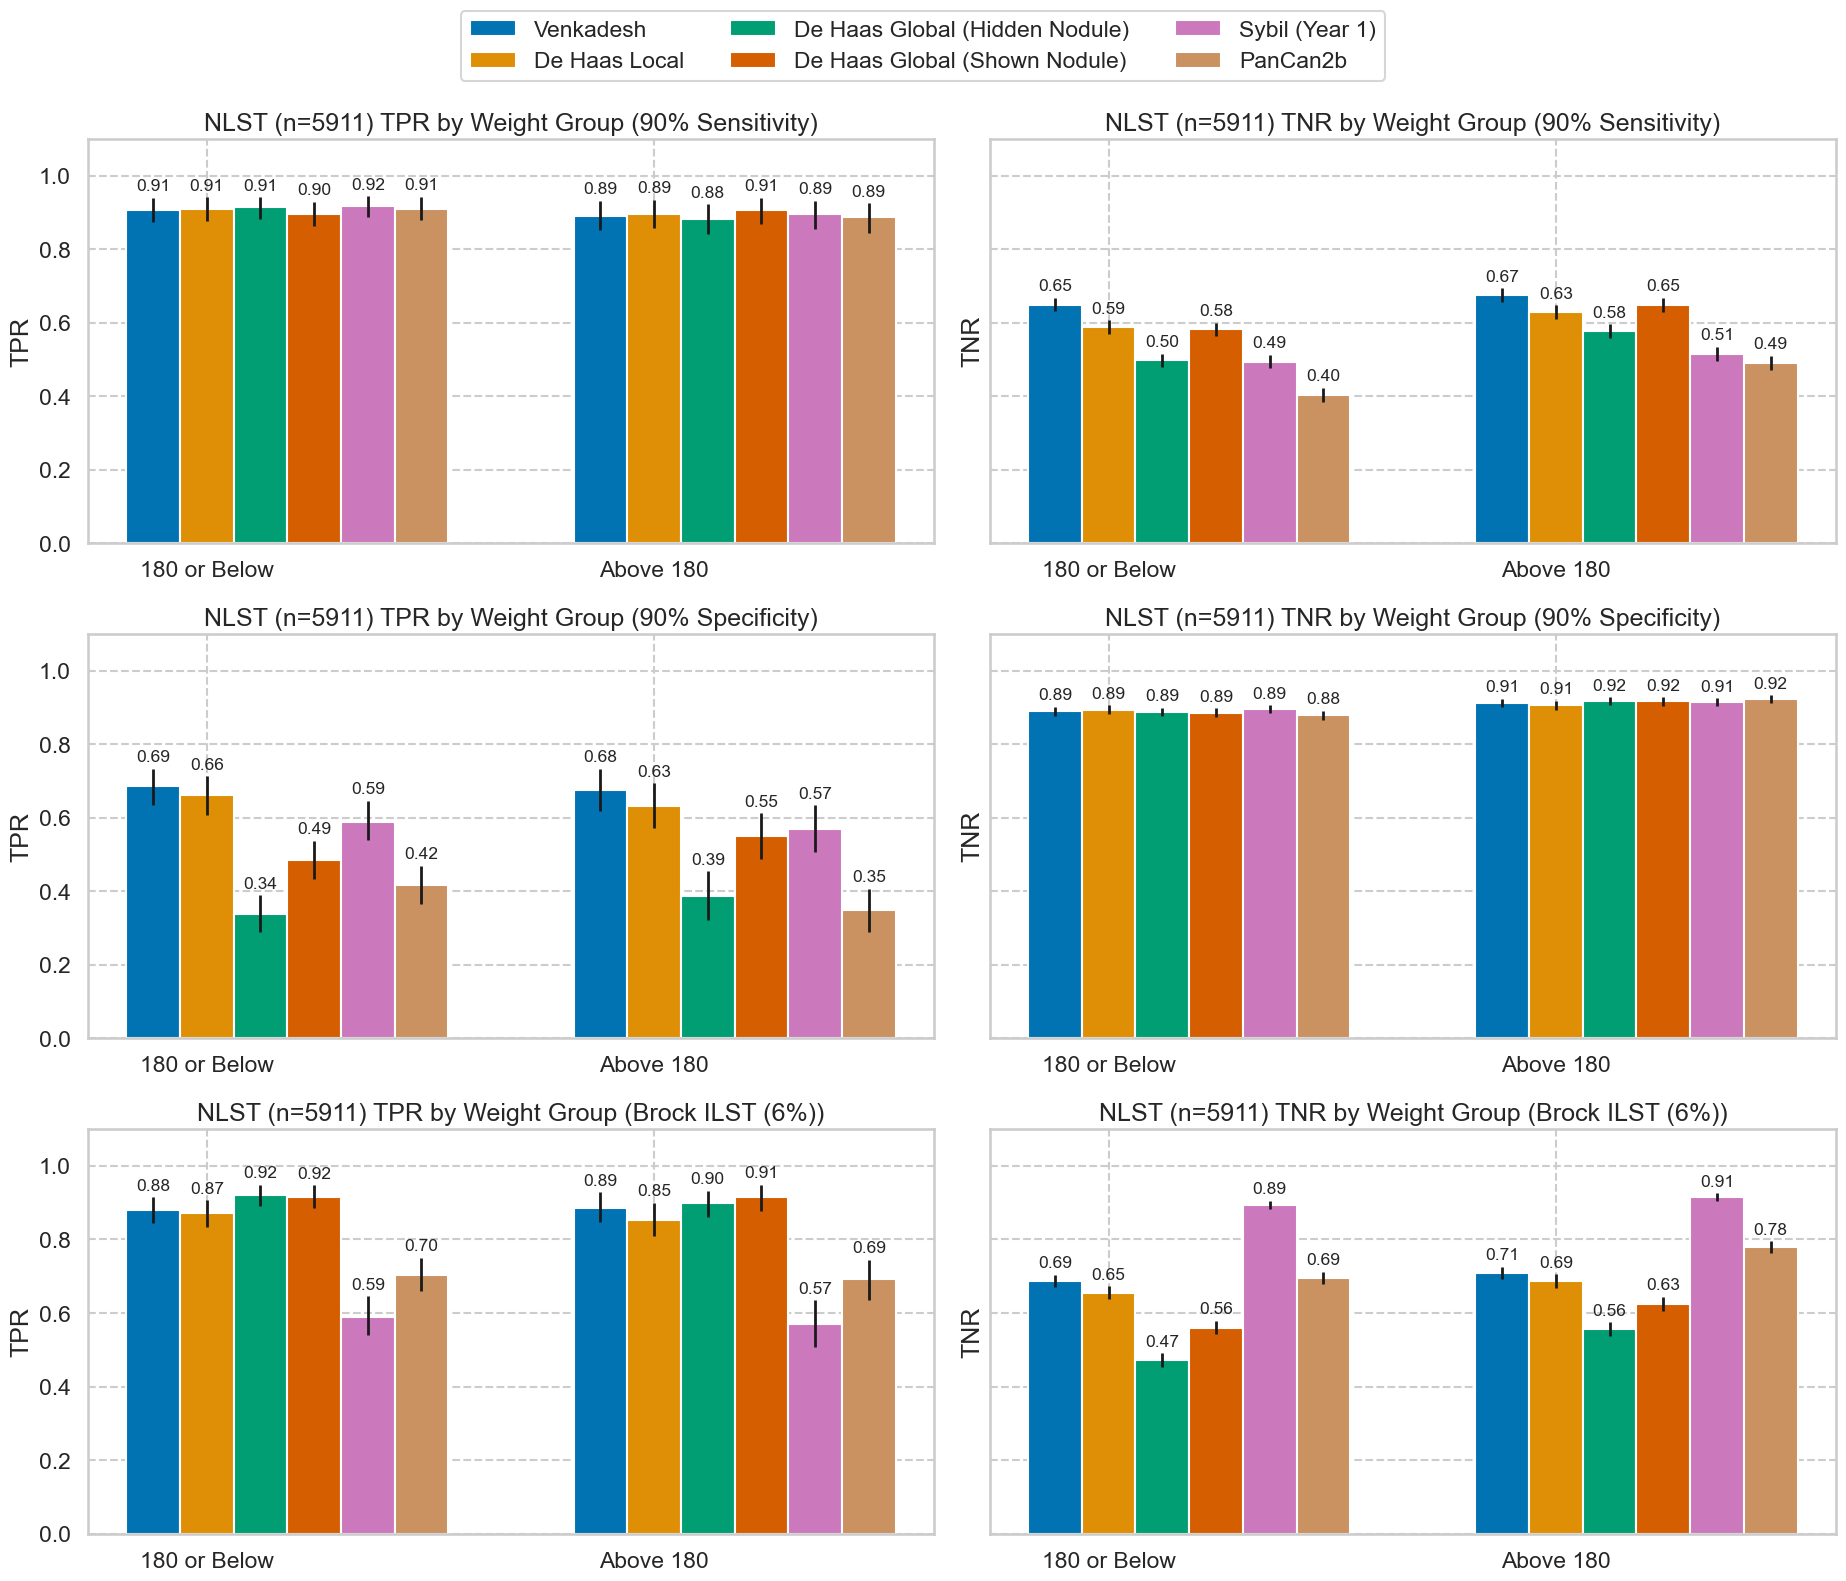

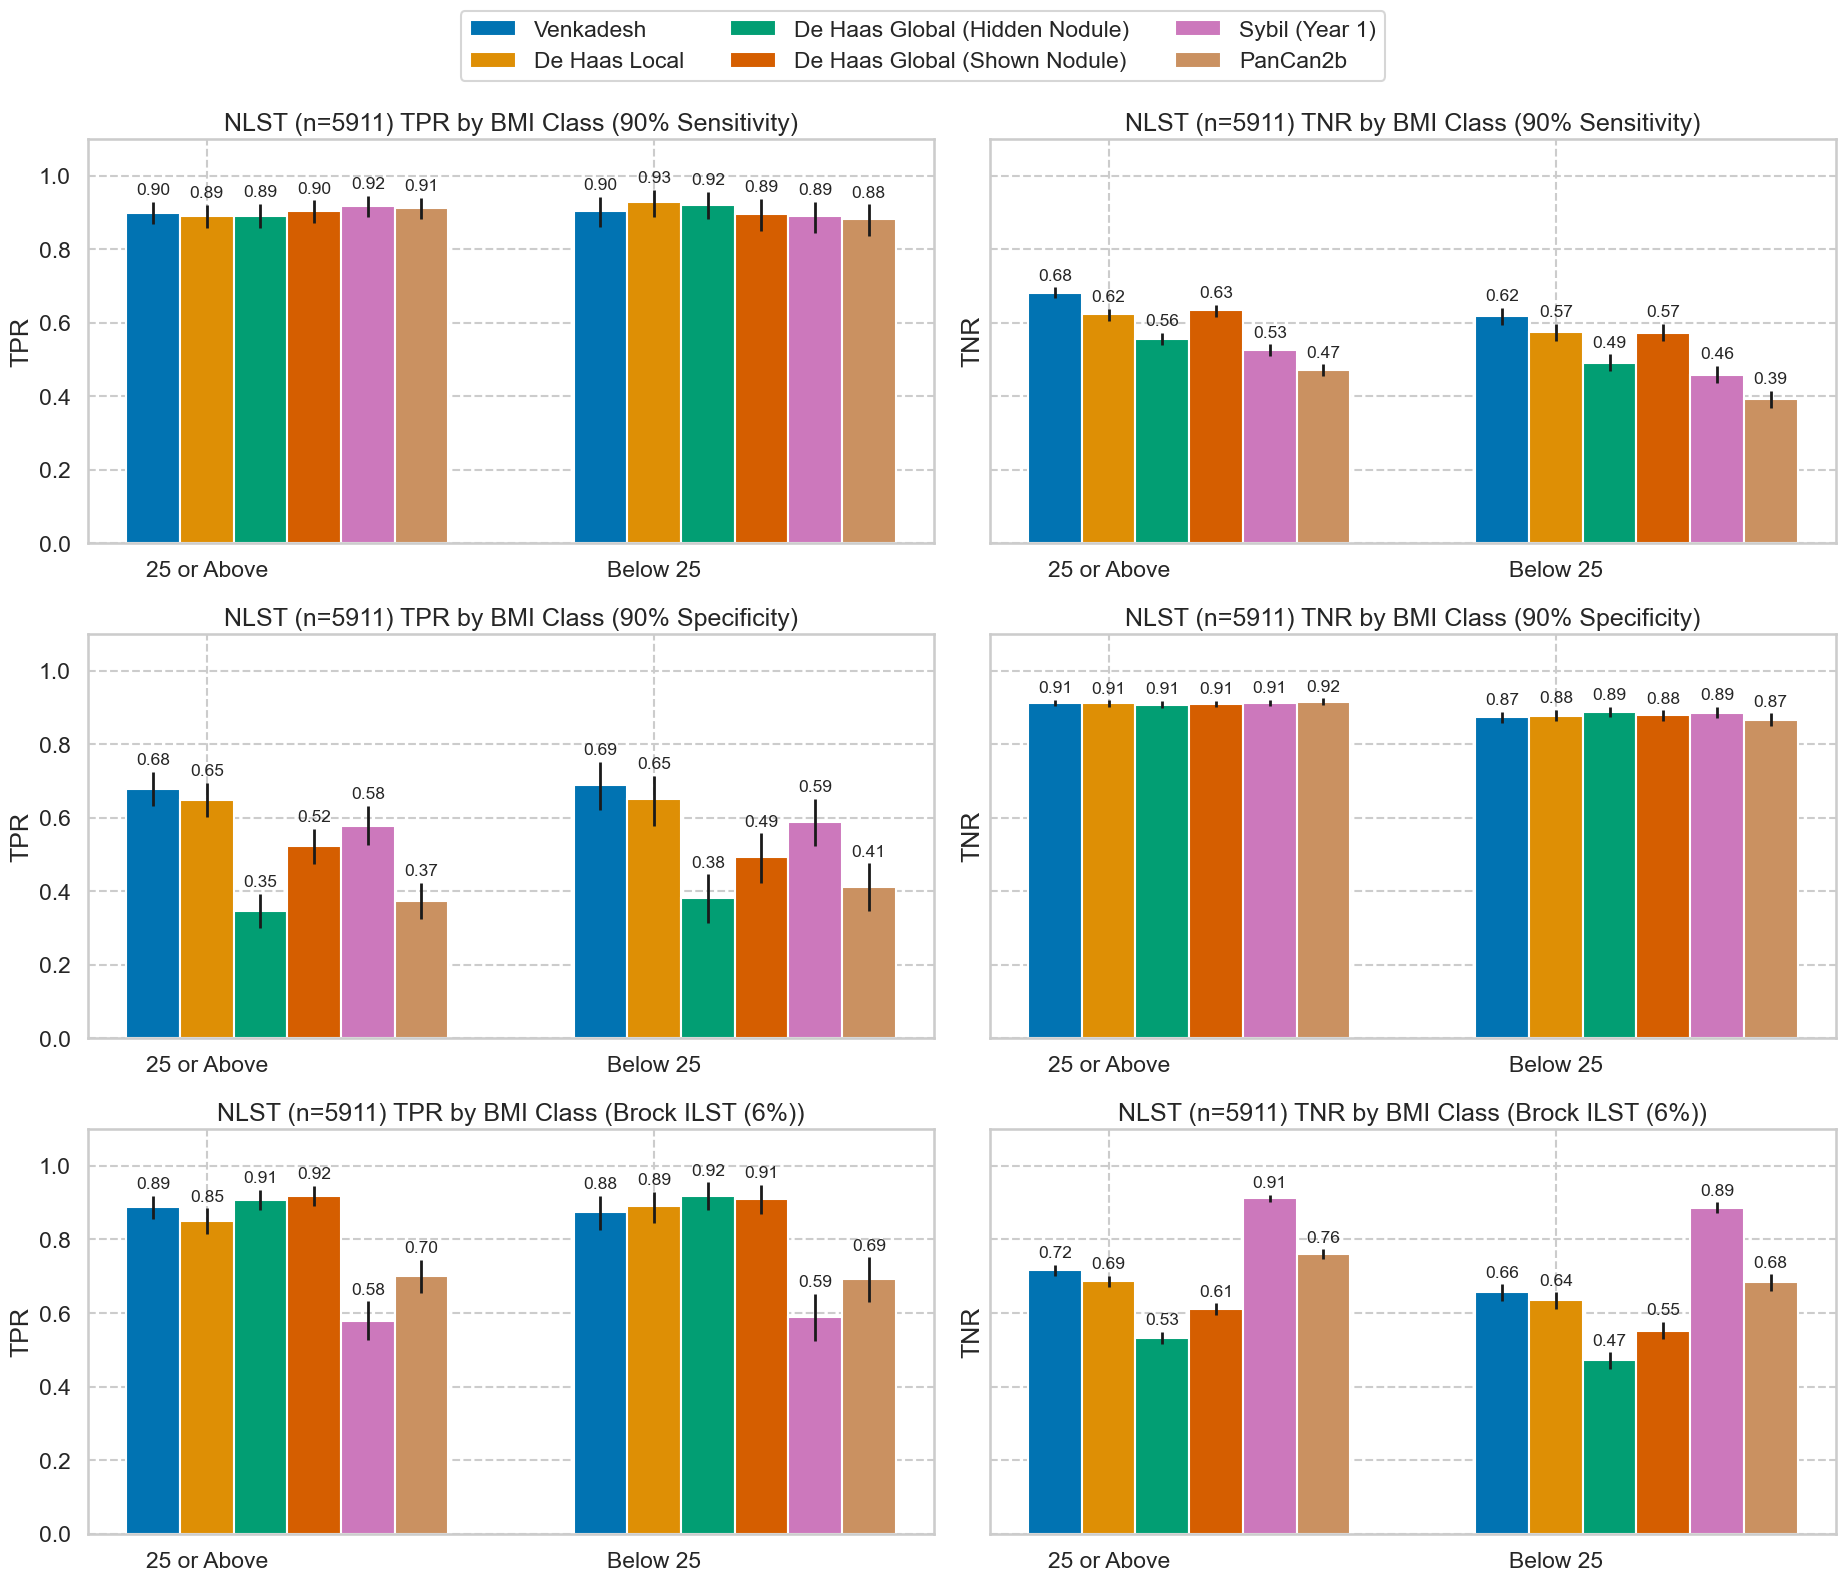

In [47]:
print(nlst_demos_to_include)
for col in nlst_demos_to_include:
    _ = threshold.plot_threshold_stats_subgroups(nlst_5911, col, dataset_name='NLST',
                                                policies=nlst_5911_policies, models=NLST_5911_MODELCOLS, 
                                                stats=threshold_nlst_5911.query(f'attribute == "{col}"'),
                                                plot_metrics=['TPR', 'TNR'], diff=False, show_mb_count=False,
                                                imgpath=f"{FIG_DIR}/threshold-NLST-5911/{col}.png"
                                                )  

## Threshold Tables

In [130]:
def metric_outside_ci(val_is_outside_ci):
    return "*" if val_is_outside_ci else ""

def ci_dont_intersect(ci_notouch):
    return "**" if ci_notouch else ""

def check_ci(val_is_outside_ci, ci_notouch):
    if ci_notouch and val_is_outside_ci:
        return "**"
    if ci_notouch and not val_is_outside_ci:
        return "???"
    if val_is_outside_ci and not ci_notouch:
        return "*"
    if not val_is_outside_ci and not ci_notouch:
        return ""

def threshold_results_pretty(df, model_order_0, metric='FPR', precision=TABLE_SCORE_PRECISION):
    df = df.query('Group_1 != "ALL" & Group_2 != "ALL"').drop_duplicates(subset='comp_id').query('Group_1_mal >= 10 & Group_2_mal >= 10')
    if model_order_0[0] in model_column_rename.keys():
        model_order = [model_column_rename[m] for m in model_order_0]
    else:
        model_order = model_order_0

    ## Get metric info in nice interval notation.
    df[f'Group_1_{metric}'] = df.apply(lambda row: pretty_interval(row, precision, group_num=1, metric=metric), axis=1)
    df[f'Group_2_{metric}'] = df.apply(lambda row: pretty_interval(row, precision, group_num=2, metric=metric), axis=1)
    df['CI Check'] = df.apply(lambda row: check_ci(row[f"{metric}_outside_CI"], row[f"{metric}_CI_notouch"]), axis=1)
    df['comp_id'] = df.apply(lambda row: row['comp_id'].split(row['policy'])[1][1:], axis=1)

    # df1 = df[['comp_id', 'model', 'policy', 'category', 'attribute', 'Group_1', f'Group_1_{metric}', 'Group_1_mal', f"{metric}_outside_CI"]].rename(columns={
    #     'Group_1': 'Group', f'Group_1_{metric}': metric, 'Group_1_mal': 'Malignant Scans', f"{metric}_outside_CI": 'CI Check'})
    # df1['CI Check'] = df1.apply(lambda row: metric_outside_ci(row['CI Check']), axis=1)
    # df1['comp_id'] = df1.apply(lambda row: row['comp_id'].split(row['policy'])[1][1:], axis=1)
    # df2 = df[['comp_id', 'model', 'policy', 'category', 'attribute', 'Group_2', f'Group_2_{metric}', 'Group_2_mal', f"{metric}_CI_notouch"]].rename(columns={
    #     'Group_2': 'Group', f'Group_2_{metric}': metric, 'Group_2_mal': 'Malignant Scans', f"{metric}_CI_notouch": 'CI Check'})
    # df2['CI Check'] = df2.apply(lambda row: ci_dont_intersect(row['CI Check']), axis=1)
    # df2['comp_id'] = df2.apply(lambda row: row['comp_id'].split(row['policy'])[1][1:], axis=1)
    # df_res = pd.concat([df1, df2])

    df_res = df[['comp_id', 'model', 'policy', 'category', 'attribute', 'Group_1', f'Group_1_{metric}', 'Group_1_mal', 'Group_2', f'Group_2_{metric}', 'Group_2_mal', 'CI Check']]

    if df_res['category'].iloc[0] in data.rename_types.keys():
        df_res['Category'] = df_res.apply(lambda row: data.rename_types[row['category']], axis=1)
    else:
        df_res['Category'] = df_res['category']
    
    if df_res['attribute'].iloc[0] in data.rename_cols.keys():
        df_res['Attribute'] = df_res.apply(lambda row: prettify_result_val(row['attribute'], row['Group'])[0], axis=1)
        df_res['Group'] = df_res.apply(lambda row: prettify_result_val(row['attribute'], row['Group'])[1], axis=1)
    else:
        df_res['Attribute'] = df_res['attribute']
    
    df_res = df_res.set_index(pd.MultiIndex.from_frame(df_res[['policy', 'Category', 'Attribute', 'Group_1', 'Group_2']]))
    model_results = {m: dfm[[f'Group_1_{metric}', f'Group_2_{metric}', "CI Check"]] for m, dfm in df_res.groupby('model')}
    df_out = pd.concat(model_results, axis=1)
    # df_out['Malignant Scans'] = df_res['Malignant Scans'].drop_duplicates()
    # df_out = df_out.merge(df_res[['Group_1', 'Group_2']].drop_duplicates(), how='left', validate='m:1')
    # df_out['g1'] = df_res['Group_1'].drop_duplicates()
    # df_out['g2'] = df_res['Group_2'].drop_duplicates()
    # df_out = df_out.sort_values(by='Malignant Scans', ascending=False)
    df_out = df_out.sort_index(ascending=True, level=['policy', 'Category', 'Attribute'], sort_remaining=False)[model_order]
    return df_out

In [70]:
PRETTY_MODELS = {
    'Venkadesh': 'DL_cal',
    'De Haas Combined': 'Thijmen_mean_cal', 
    'Sybil (Year 1)': 'sybil_year1', 
    'De Haas Local': 'Thijmen_local_cal',
    'De Haas Global (Hidden Nodule)': 'Thijmen_global_hidden_cal',
    'De Haas Global (Shown Nodule)': "Thijmen_global_show_cal",
    'PanCan2b': 'PanCan2b'
}

thres_test = threshold.all_attribute_pairwise_comparisons(threshold_nlst_5911, metric="TPR", models=PRETTY_MODELS)
display(thres_test)

In [88]:
thres_test

comp_id  \
0   Demographics_Age Group_TPR_De Haas Global (Hid...   
1   Demographics_Age Group_TPR_De Haas Global (Hid...   
2   Demographics_Age Group_TPR_De Haas Global (Hid...   
3   Demographics_Age Group_TPR_De Haas Global (Hid...   
4   Demographics_Age Group_TPR_De Haas Global (Hid...   
..                                                ...   
1   Work History_Welding_TPR_Venkadesh_Specificity...   
2   Work History_Welding_TPR_Venkadesh_Specificity...   
3   Work History_Welding_TPR_Venkadesh_Specificity...   
4   Work History_Welding_TPR_Venkadesh_Specificity...   
5   Work History_Welding_TPR_Venkadesh_Specificity...   

                             model           policy      Group_1      Group_2  \
0   De Haas Global (Hidden Nodule)  90% Sensitivity          ALL  61 or Below   
1   De Haas Global (Hidden Nodule)  90% Sensitivity          ALL     Above 61   
2   De Haas Global (Hidden Nodule)  90% Sensitivity  61 or Below          ALL   
3   De Haas Global (Hidden Nodule)  90% Sensitivity  61 or Below     Above 61   
4   De Haas Global (Hidden Nodule)  90% Sensitivity     Above 61          ALL   
..                             ...              ...          ...          ...   
1                        Venkadesh  Specificity=1.0          ALL          1.0   
2                        Venkadesh  Specificity=1.0          0.0          ALL   
3                        Venkadesh  Specificity=1.0          0.0          1.0   
4                        Venkadesh  Specificity=1.0          1.0          ALL   
5                        Venkadesh  Specificity=1.0          1.0          0.0   

       TPR_1  TPR-CI-lo_1  TPR-CI-hi_1     TPR_2  TPR-CI-lo_2  ...   tp_2  \
0   0.900172     0.874775     0.923339  0.914798     0.876022  ...  204.0   
1   0.900172     0.874775     0.923339  0.891061     0.856741  ...  319.0   
2   0.914798     0.876022     0.948604  0.900172     0.874775  ...  523.0   
3   0.914798     0.876022     0.948604  0.891061     0.856741  ...  319.0   
4   0.891061     0.856741     0.922255  0.900172     0.874775  ...  523.0   
..       ...          ...          ...       ...          ...  ...    ...   
1   0.048193     0.032783     0.064866  0.075000     0.000000  ...    3.0   
2   0.046296     0.029905     0.063753  0.048193     0.032783  ...   28.0   
3   0.046296     0.029905     0.063753  0.075000     0.000000  ...    3.0   
4   0.075000     0.000000     0.166667  0.048193     0.032783  ...   28.0   
5   0.075000     0.000000     0.166667  0.046296     0.029905  ...   25.0   

      tn_1    tn_2    fp_1    fp_2   fn_1   fn_2                        col  \
0   2855.0  1256.0  2475.0  1107.0   58.0   19.0  Thijmen_global_hidden_cal   
1   2855.0  1599.0  2475.0  1368.0   58.0   39.0  Thijmen_global_hidden_cal   
2   1256.0  2855.0  1107.0  2475.0   19.0   58.0  Thijmen_global_hidden_cal   
3   1256.0  1599.0  1107.0  1368.0   19.0   39.0  Thijmen_global_hidden_cal   
4   1599.0  2855.0  1368.0  2475.0   39.0   58.0  Thijmen_global_hidden_cal   
..     ...     ...     ...     ...    ...    ...                        ...   
1   5330.0   320.0     0.0     0.0  553.0   37.0                     DL_cal   
2   5010.0  5330.0     0.0     0.0  515.0  553.0                     DL_cal   
3   5010.0   320.0     0.0     0.0  515.0   37.0                     DL_cal   
4    320.0  5330.0     0.0     0.0   37.0  553.0                     DL_cal   
5    320.0  5010.0     0.0     0.0   37.0  515.0                     DL_cal   

    attribute      category  
0   Age Group  Demographics  
1   Age Group  Demographics  
2   Age Group  Demographics  
3   Age Group  Demographics  
4   Age Group  Demographics  
..        ...           ...  
1     Welding  Work History  
2     Welding  Work History  
3     Welding  Work History  
4     Welding  Work History  
5     Welding  Work History  

[32760 rows x 29 columns]

In [132]:
threshold_tpr = threshold_results_pretty(thres_test, model_order_0=list(pd.unique(thres_test['model'])), metric='TPR')
threshold_tpr.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include')

C:\Users\shaur\AppData\Local\Temp\ipykernel_11792\2953373118.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res['Category'] = df_res['category']
C:\Users\shaur\AppData\Local\Temp\ipykernel_11792\2953373118.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res['Attribute'] = df_res['attribute']


De Haas Global (Hidden Nodule)  \
                                                                         Group_1_TPR   
policy          Attribute    Group_1      Group_2                                      
90% Sensitivity Age Group    61 or Below  Above 61                 0.91 (0.88, 0.95)   
                BMI Class    Below 25     25 or Above              0.92 (0.88, 0.96)   
                Gender       Male         Female                   0.91 (0.88, 0.94)   
                Height Group 68 or Below  Above 68                 0.90 (0.87, 0.93)   
                Race         White        Black                    0.90 (0.87, 0.92)   
                Weight Group 180 or Below Above 180                0.91 (0.88, 0.94)   
90% Specificity Age Group    61 or Below  Above 61                 0.36 (0.30, 0.42)   
                BMI Class    Below 25     25 or Above              0.38 (0.32, 0.45)   
                Gender       Male         Female                   0.39 (0.34, 0.45)   
                Height Group 68 or Below  Above 68                 0.35 (0.30, 0.40)   
                Race         White        Black                    0.36 (0.32, 0.40)   
                Weight Group 180 or Below Above 180                0.34 (0.29, 0.39)   
Brock ILST (6%) Age Group    61 or Below  Above 61                 0.93 (0.89, 0.96)   
                BMI Class    Below 25     25 or Above              0.92 (0.88, 0.96)   
                Gender       Male         Female                   0.92 (0.89, 0.95)   
                Height Group 68 or Below  Above 68                 0.91 (0.88, 0.94)   
                Race         White        Black                    0.91 (0.89, 0.94)   
                Weight Group 180 or Below Above 180                0.92 (0.89, 0.95)   
Sensitivity=1.0 Age Group    61 or Below  Above 61                 1.00 (1.00, 1.00)   
                BMI Class    Below 25     25 or Above              1.00 (1.00, 1.00)   
                Gender       Male         Female                   1.00 (1.00, 1.00)   
                Height Group 68 or Below  Above 68                 1.00 (1.00, 1.00)   
                Race         White        Black                    1.00 (1.00, 1.00)   
                Weight Group 180 or Below Above 180                1.00 (1.00, 1.00)   
Specificity=1.0 Age Group    61 or Below  Above 61                 0.00 (0.00, 0.00)   
                BMI Class    Below 25     25 or Above              0.00 (0.00, 0.00)   
                Gender       Male         Female                   0.00 (0.00, 0.01)   
                Height Group 68 or Below  Above 68                 0.00 (0.00, 0.01)   
                Race         White        Black                    0.00 (0.00, 0.01)   
                Weight Group 180 or Below Above 180                0.00 (0.00, 0.00)   

                                                                          \
                                                             Group_2_TPR   
policy          Attribute    Group_1      Group_2                          
90% Sensitivity Age Group    61 or Below  Above 61     0.89 (0.86, 0.92)   
                BMI Class    Below 25     25 or Above  0.89 (0.86, 0.92)   
                Gender       Male         Female       0.89 (0.85, 0.93)   
                Height Group 68 or Below  Above 68     0.90 (0.86, 0.93)   
                Race         White        Black        0.96 (0.88, 1.00)   
                Weight Group 180 or Below Above 180    0.88 (0.84, 0.92)   
90% Specificity Age Group    61 or Below  Above 61     0.36 (0.31, 0.41)   
                BMI Class    Below 25     25 or Above  0.35 (0.30, 0.39)   
                Gender       Male         Female       0.31 (0.25, 0.37)   
                Height Group 68 or Below  Above 68     0.37 (0.31, 0.43)   
                Race         White        Black        0.29 (0.13, 0.48)   
                Weight Group 180 or Below Above 180    0.39 (0.32, 0.45)   
Brock ILS

## Demographic Confounder Links

In [49]:
def num_with_percent(x, s, precision):
    return f'{0 if np.isnan(x[f"{s}_freq"]) else int(x[f"{s}_freq"])} ({0 if np.isnan(x[f"{s}_norm"]) else np.around(x[f"{s}_norm"], precision)})'

def confounders_by_attribute(df, attribute, cols, precision=1):
    dfsets = {val: dfv for val, dfv in df.groupby(attribute)}
    subgroups = list(dfsets.keys())
    subgroups_pretty_key = {sg: prettify_result_val(attribute, sg)[1] for sg in subgroups}

    cat_df = data.combine_diff_dfs(cols['cat'], data.diffs_category_prevalence, dfsets)
    for s in dfsets:
        cat_df[f"{subgroups_pretty_key[s]} Prevalence (\%)"] = cat_df.apply(lambda x: num_with_percent(x, s, precision), axis=1)

    cat_df = cat_df[pd.notna(cat_df['value'])]
    cat_df['category'] = cat_df.apply(lambda row: data.rename_types[row['category']], axis=1)
    cat_df['attribute2'] = cat_df.apply(lambda row: prettify_result_val(row['attribute'], row['value'])[0], axis=1)
    cat_df['value'] = cat_df.apply(lambda row: prettify_result_val(row['attribute'], row['value'])[1], axis=1)
    cat_df['attribute'] = cat_df['attribute2']
    cat_df = cat_df.set_index(pd.MultiIndex.from_frame(cat_df[['category', 'attribute', 'value']]))

    cat_df = cat_df[cat_df['attribute'] != attribute]
    cat_df = cat_df[[f"{subgroups_pretty_key[s]} Prevalence (\%)" for s in subgroups] + [f"diff_{s1}_{s2}" for s1, s2 in itertools.combinations(subgroups, 2)]]
    # cat_df = cat_df.sort_values(by=f"diff_{subgroups[0]}_{subgroups[1]}", ascending=True)
    cat_df = cat_df.sort_index(ascending=True)

    num_df = data.combine_diff_dfs(cols['num'], data.diffs_numerical_means, dfsets)
    num_df['category'] = num_df.apply(lambda row: data.rename_types[row['category']], axis=1)
    num_df['attribute2'] = num_df.apply(lambda row: prettify_result_val(row['attribute'], row['value'])[0], axis=1)
    num_df['value'] = num_df.apply(lambda row: prettify_result_val(row['attribute'], row['value'])[1], axis=1)
    num_df['attribute'] = num_df['attribute2']
    num_df = num_df.set_index(pd.MultiIndex.from_frame(num_df[['category', 'attribute', 'value']]))

    num_df = num_df[num_df['attribute'] != attribute]
    num_df = num_df[num_df['value'].isin(['Median (IQR)'])]
    num_df = num_df[[f"{s}" for s in subgroups] + [f"diff_{s1}_{s2}" for s1, s2 in itertools.combinations(subgroups, 2)]]
    num_df = num_df.rename(columns={f"{s}": subgroups_pretty_key[s] for s in subgroups})
    # num_df = num_df.sort_values(by=f"diff_{subgroups[0]}_{subgroups[1]}", ascending=True)
    num_df = num_df.sort_index(ascending=True)

    if len(subgroups) == 2:
        rename_diff = {f"diff_{subgroups[0]}_{subgroups[1]}": "Difference"}
        cat_df.rename(columns=rename_diff, inplace=True)
        num_df.rename(columns=rename_diff, inplace=True)
        cat_df["Abs Diff"] = cat_df['Difference'].abs()

    return cat_df, num_df

In [50]:
nlst_5911_v2, nlst_cols_v2, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=False, bin_num=True)
nlst_cols_v2

{'num': {'demo': ['BMI', 'Age', 'height', 'weight'],
  'smoke': ['smokeage', 'smokeday', 'smokeyr', 'pkyr'],
  'other': ['NoduleCounts', 'Diameter_mm', 'SliceCount']},
 'cat': {'demo': ['Age > 61',
   'Gender',
   'HighSchoolPlus',
   'Married',
   'NonHispanicWhite',
   'Overweight',
   'Unfinished_ed',
   'WhiteOrBlack',
   'educat',
   'ethnic',
   'height > 68',
   'marital',
   'race',
   'weight > 180'],
  'smoke': ['cigar',
   'cigsmok',
   'pipe',
   'pkyr > 55',
   'smokeage > 16',
   'smokeday > 25',
   'smokelive',
   'smokework',
   'smokeyr > 40'],
  'work': ['wrkbaki',
   'wrkfoun',
   'wrkchem',
   'wrkasbe',
   'wrkfire',
   'wrksand',
   'wrkfarm',
   'wrkcoal',
   'wrkpain',
   'wrkweld',
   'wrkflou',
   'wrkbutc',
   'wrkhard',
   'wrkcott'],
  'disease': ['diagasbe',
   'diagchas',
   'diagpneu',
   'diagstro',
   'diagemph',
   'diagbron',
   'diagsili',
   'diagsarc',
   'diaghear',
   'diagdiab',
   'diagadas',
   'diagcopd',
   'diagfibr',
   'diagtube',
   'di

In [51]:
def sort_multiindex_by_attribute(df, col='Abs Diff'):
    attribute_max = df.groupby('attribute')[col].max()
    sorted_attributes = attribute_max.sort_values(ascending=False).index

    df2 = df.reset_index()
    df2['attribute'] = pd.Categorical(df2['attribute'], categories=sorted_attributes, ordered=True)
    df2 = df2.sort_values('attribute')
    df2 = df2.set_index(['category', 'attribute', 'value'])
    return df2 

In [52]:
cat_gender, num_gender = confounders_by_attribute(nlst_5911_v2, 'Gender', nlst_cols_v2)
display(cat_gender)
display(num_gender)

cat_gender = sort_multiindex_by_attribute(cat_gender, 'Abs Diff')
cat_gender

Male Prevalence (\%)  \
category     attribute        value                                    
Demographics Age Group        61 or Below                1461 (42.5)   
                              Above 61                   1980 (57.5)   
             BMI Class        25 or Above                2538 (73.8)   
                              Below 25                    903 (26.2)   
             Education Status 8th grade or less             95 (2.8)   
...                                                              ...   
Work History Painting         1.0                          267 (7.8)   
             Sandblasting     0.0                        3341 (97.1)   
                              1.0                           99 (2.9)   
             Welding          0.0                        3099 (90.1)   
                              1.0                          341 (9.9)   

                                                Female Prevalence (\%)  \
category     attribute        value                                      
Demographics Age Group        61 or Below                  1125 (45.5)   
                              Above 61                     1345 (54.5)   
             BMI Class        25 or Above                  1474 (59.7)   
                              Below 25                      996 (40.3)   
             Education Status 8th grade or less               16 (0.6)   
...                                                                ...   
Work History Painting         1.0                             50 (2.0)   
             Sandblasting     0.0                          2459 (99.6)   
                              1.0                             11 (0.4)   
             Welding          0.0                          2451 (99.2)   
                              1.0                             19 (0.8)   

                                                 Difference  Abs Diff  
category     attribute        value                                    
Demographics Age Group        61 or Below           -3.0880    3.0880  
                              Above 61               3.0880    3.0880  
             BMI Class        25 or Above           14.0815   14.0815  
                              Below 25             -14.0815   14.0815  
             Education Status 8th grade or less      2.1130    2.1130  
...                                                     ...       ...  
Work History Painting         1.0                    5.7351    5.7351  
             Sandblasting     0.0                   -2.4608    2.4608  
                              1.0                    2.4318    2.4318  
             Welding          0.0                   -9.1698    9.1698  
                              1.0                    9.1407    9.1407  

[225 rows x 4 columns]

Male    Female  \
category     attribute                 value                              
Demographics Age                       Median (IQR)    63 (8)    62 (8)   
             BMI                       Median (IQR)    27 (5)    26 (7)   
             Height                    Median (IQR)    71 (3)    64 (3)   
             Weight                    Median (IQR)  192 (46)  157 (45)   
Other        Diameter (mm)             Median (IQR)     7 (5)     7 (4)   
             Nodules Per Scan          Median (IQR)     1 (1)     1 (1)   
             Slices In Scan            Median (IQR)  165 (36)  155 (36)   
Smoking      Age at Smoking Onset      Median (IQR)    16 (4)    17 (4)   
             Cigarettes per Day (avg.) Median (IQR)   30 (20)   20 (10)   
             Pack-Years                Median (IQR)   55 (35)   46 (22)   
             Total Years of Smoking    Median (IQR)   42 (10)    40 (9)   

                                                     Difference  
category     attribute                 value                     
Demographics Age                       Median (IQR)       1.000  
             BMI                       Median (IQR)       0.888  
             Height                    Median (IQR)       7.000  
             Weight                    Median (IQR)      35.000  
Other        Diameter (mm)             Median (IQR)       0.200  
             Nodules Per Scan          Median (IQR)       0.000  
             Slices In Scan            Median (IQR)      10.000  
Smoking      Age at Smoking Onset      Median (IQR)      -1.000  
             Cigarettes per Day (avg.) Median (IQR)      10.000  
             Pack-Years                Median (IQR)       9.000  
             Total Years of Smoking    Median (IQR)       2.000

Male Prevalence (\%)  \
category     attribute          value                               
Demographics Height Group       Above 68              2621 (76.2)   
                                68 or Below            820 (23.8)   
             Weight Group       180 or Below          1215 (35.3)   
                                Above 180             2226 (64.7)   
Smoking      Smoked Pipe        1.0                   1256 (36.5)   
...                                                           ...   
Nodule       Non-Solid          True                     31 (0.9)   
             Calcified          True                      3 (0.1)   
                                False                 3438 (99.9)   
Demographics Non-Hispanic White False                   280 (8.1)   
                                True                  3161 (91.9)   

                                             Female Prevalence (\%)  \
category     attribute          value                                 
Demographics Height Group       Above 68                  146 (5.9)   
                                68 or Below             2324 (94.1)   
             Weight Group       180 or Below            1880 (76.1)   
                                Above 180                590 (23.9)   
Smoking      Smoked Pipe        1.0                        45 (1.8)   
...                                                             ...   
Nodule       Non-Solid          True                       22 (0.9)   
             Calcified          True                        2 (0.1)   
                                False                   2468 (99.9)   
Demographics Non-Hispanic White False                     201 (8.1)   
                                True                    2269 (91.9)   

                                              Difference  Abs Diff  
category     attribute          value                               
Demographics Height Group       Above 68         70.2588   70.2588  
                                68 or Below     -70.2588   70.2588  
             Weight Group       180 or Below    -40.8039   40.8039  
                                Above 180        40.8039   40.8039  
Smoking      Smoked Pipe        1.0              34.6791   34.6791  
...                                                  ...       ...  
Nodule       Non-Solid          True              0.0102    0.0102  
             Calcified          True              0.0062    0.0062  
                                False            -0.0062    0.0062  
Demographics Non-Hispanic White False            -0.0005    0.0005  
                                True              0.0005    0.0005  

[225 rows x 4 columns]

In [53]:
# nlst_5911_v2, nlst_cols_v2, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
cat_race, num_race = confounders_by_attribute(nlst_5911_v2, 'WhiteOrBlack', nlst_cols_v2)

## ROC isolating for confounders

In [54]:
def roc_isolations_pretty(df0, attribute, model, precision=TABLE_SCORE_PRECISION):
    df = df0.rename(index=model_column_rename)
    df.reset_index(inplace=True, names='model')
    df = df.query(f'model == "{model}"')

    ## Get AUC info in nice interval notation.
    df['Group_1_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=1), axis=1)
    df['Group_2_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=2), axis=1)

    df['category'] = df.apply(lambda row: data.rename_types[row['category']], axis=1)
    df['attribute'] = df.apply(lambda row: prettify_result_val(row['filter_by'], row['filter_val'])[0], axis=1)
    df['value'] = df.apply(lambda row: prettify_result_val(row['filter_by'], row['filter_val'])[1], axis=1)
    df['P'] = df.apply(lambda row: data.truncate_p(row['p']), axis=1)
    df = df.set_index(pd.MultiIndex.from_frame(df[['category', 'attribute', 'value']]))

    ## Get list of subgroups.
    subgroups = list(set(list(pd.unique(df['Group_1'])) + list(pd.unique(df['Group_2']))))
    subgroups_pretty_key = {sg: prettify_result_val(attribute, sg)[1] for sg in subgroups}
    
    ## Group 1 and Group 2 don't necessarily always align. We need to realign them.
    cols_to_realign = ['mal', 'ben', 'pct', 'pct_mal', 'AUC']
    def realign_group_num(row, subgroup, col='AUC'):
        if row['Group_1'] == subgroup:
            return row[f'Group_1_{col}']
        if row['Group_2'] == subgroup:
            return row[f'Group_2_{col}']
        else: 
            return None
    
    for sg in subgroups:
        for c in cols_to_realign:
            df[f"{subgroups_pretty_key[sg]} {c}"] = df.apply(lambda row: realign_group_num(row, sg, c), axis=1)
    
    df = df[['p', 'P', 'AUC_diff'] + [f"{subgroups_pretty_key[sg]} {col}" for sg, col in itertools.product(subgroups, cols_to_realign)]]
    # df = df[['p'] + [f"{subgroups_pretty_key[sg]} AUC" for sg in subgroups]]
    return df

In [55]:
def prevalence_plus_isolated_roc(dataset, attribute, cols, results, model, data_precision=1, result_precision=TABLE_SCORE_PRECISION):
    cat_prev, _ = confounders_by_attribute(dataset, attribute, cols, precision=data_precision)
    roc_results = roc_isolations_pretty(results, attribute, model, precision=result_precision)
    combined_df = pd.concat([cat_prev, roc_results], axis=1).dropna(axis=0)

    subgroups = list(set(list(pd.unique(results['Group_1'])) + list(pd.unique(results['Group_2']))))
    subgroups_pretty = [prettify_result_val(attribute, sg)[1] for sg in subgroups]
    subcols_to_align = ["Prevalence (\\%)", 'AUC', 'mal', 'ben', 'pct', 'pct_mal']
    other_cols = ['Difference', 'Abs Diff', 'p', 'P', 'AUC_diff']

    combined_df = combined_df[[f"{s} {c}" for s, c in itertools.product(subgroups_pretty, subcols_to_align)] + other_cols]
    multicol_idx = pd.MultiIndex.from_tuples(list(itertools.product(subgroups_pretty, subcols_to_align))).append(pd.Index(other_cols))
    combined_df.columns = multicol_idx
    return combined_df

In [56]:
gender_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-gender-by-factors-nlst-5911.csv', index_col=0)
gender_prevalences_roc = prevalence_plus_isolated_roc(nlst_5911_v2, 'Gender', nlst_cols_v2, gender_roc, 'Sybil (Year 1)')
gender_result = sort_multiindex_by_attribute(gender_prevalences_roc, col='Abs Diff').query("`Abs Diff` > 10")
gender_result

C:\Users\shaur\AppData\Local\Temp\ipykernel_17688\309828871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Group_1_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=1), axis=1)
C:\Users\shaur\AppData\Local\Temp\ipykernel_17688\309828871.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Group_2_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=2), axis=1)
C:\Users\shaur\AppData\Local\Temp\ipykernel_17688\309828871.py:10: SettingWithCopyWarning: 
A valu

(Male, Prevalence (\%))  \
category     attribute                       value                                  
Demographics Height Group                    Above 68                 2621 (76.2)   
                                             68 or Below               820 (23.8)   
             Weight Group                    Above 180                2226 (64.7)   
                                             180 or Below             1215 (35.3)   
             Marital Status                  Married                  2669 (77.6)   
                                             Divorced                  477 (13.9)   
                                             Widowed                    127 (3.7)   
Other        Work Without Mask               True                     1184 (34.4)   
                                             False                    2257 (65.6)   
Smoking      Pack-Years Group                55 or Below              1742 (50.6)   
                                             Above 55                 1699 (49.4)   
Demographics BMI Class                       Below 25                  903 (26.2)   
                                             25 or Above              2538 (73.8)   
Smoking      Cigarettes per Day (avg.) Group Above 25                 1827 (53.1)   
                                             25 or Below              1614 (46.9)   

                                                                 (Male, AUC)  \
category     attribute                       value                             
Demographics Height Group                    Above 68      0.80 (0.77, 0.83)   
                                             68 or Below   0.84 (0.79, 0.88)   
             Weight Group                    Above 180     0.83 (0.80, 0.86)   
                                             180 or Below  0.77 (0.72, 0.82)   
             Marital Status                  Married       0.81 (0.78, 0.84)   
                                             Divorced      0.83 (0.78, 0.88)   
                                             Widowed       0.90 (0.72, 1.00)   
Other        Work Without Mask               True          0.79 (0.74, 0.84)   
                                             False         0.82 (0.79, 0.85)   
Smoking      Pack-Years Group                55 or Below   0.81 (0.77, 0.85)   
                                             Above 55      0.80 (0.77, 0.84)   
Demographics BMI Class                       Below 25      0.76 (0.70, 0.82)   
                                             25 or Above   0.83 (0.80, 0.86)   
Smoking      Cigarettes per Day (avg.) Group Above 25      0.82 (0.78, 0.85)   
                                             25 or Below   0.80 (0.76, 0.84)   

                                                           (Male, mal)  \
category     attribute                       value                       
Demographics Height Group                    Above 68            257.0   
                                             68 or Below          80.0   
             Weight Group                    Above 180           211.0   
                                             180 or Below        126.0   
             Marital Status                  Married             262.0   
                                             Divorced             54.0   
                                             Widowed               9.0   
Other        Work Without Mask               True                109.0   
                                             False               228.0   
Smoking      Pack-Years Group                55 or Below         141.0   
                                             Above 55            196.0   
Demographics BMI Class                       Below 25             92.0   
                                             25 or Above         245.0   
Smoking      Cigarettes per Day (avg.) Group Above 25            196.0   
                                             25 or Below         14

In [57]:
race_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-race-by-factors-nlst-5911.csv', index_col=0)
race_prevalences_roc = prevalence_plus_isolated_roc(nlst_5911_v2, 'WhiteOrBlack', nlst_cols_v2, race_roc, 'Sybil (Year 1)')
race_result = sort_multiindex_by_attribute(race_prevalences_roc, col='Abs Diff').query("`Abs Diff` > 10")
race_result

C:\Users\shaur\AppData\Local\Temp\ipykernel_17688\309828871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Group_1_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=1), axis=1)
C:\Users\shaur\AppData\Local\Temp\ipykernel_17688\309828871.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Group_2_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=2), axis=1)
C:\Users\shaur\AppData\Local\Temp\ipykernel_17688\309828871.py:10: SettingWithCopyWarning: 
A valu

(White, Prevalence (\%))  \
category     attribute                       value                                       
Demographics Marital Status                  Married                       3759 (68.1)   
                                             Divorced                      1015 (18.4)   
Smoking      Cigarettes per Day (avg.) Group 25 or Below                   2856 (51.7)   
                                             Above 25                      2667 (48.3)   
             Pack-Years Group                Above 55                      2397 (43.4)   
                                             55 or Below                   3126 (56.6)   
Scanner      Manufacturer                    SIEMENS                       2220 (40.2)   
             Model Name                      Sensation 16                   757 (13.7)   
Demographics Gender                          Male                          3221 (58.3)   
                                             Female                        2302 (41.7)   
             Education Status                Associate Degree              1200 (21.7)   

                                                                    (White, AUC)  \
category     attribute                       value                                 
Demographics Marital Status                  Married           0.83 (0.80, 0.85)   
                                             Divorced          0.90 (0.86, 0.93)   
Smoking      Cigarettes per Day (avg.) Group 25 or Below       0.84 (0.81, 0.86)   
                                             Above 25          0.85 (0.83, 0.87)   
             Pack-Years Group                Above 55          0.84 (0.81, 0.87)   
                                             55 or Below       0.84 (0.82, 0.87)   
Scanner      Manufacturer                    SIEMENS           0.88 (0.85, 0.90)   
             Model Name                      Sensation 16      0.85 (0.80, 0.90)   
Demographics Gender                          Male              0.81 (0.78, 0.84)   
                                             Female            0.89 (0.86, 0.91)   
             Education Status                Associate Degree  0.84 (0.81, 0.88)   

                                                               (White, mal)  \
category     attribute                       value                            
Demographics Marital Status                  Married                  354.0   
                                             Divorced                 108.0   
Smoking      Cigarettes per Day (avg.) Group 25 or Below              246.0   
                                             Above 25                 284.0   
             Pack-Years Group                Above 55                 281.0   
                                             55 or Below              249.0   
Scanner      Manufacturer                    SIEMENS                  205.0   
             Model Name                      Sensation 16              89.0   
Demographics Gender                          Male                     312.0   
                                             Female                   218.0   
             Education Status                Associate Degree         111.0   

                                                               (White, ben)  \
category     attribute                       value                            
Demographics Marital Status                  Married                 3405.0   
                                             Divorced                 907.0   
Smoking      Cigarettes per Day (avg.) Group 25 or Below             2610.0   
                                             Above 25                2383.0   
             Pack-Years Group                Above 55                2116.0   
                                             55 or Below             2877.0   
Scanner      Manufacturer                    SIEMENS                 2015.0   
             Model Name                      Sensation 16  

In [58]:
overweight_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-overweight-by-factors-nlst-5911.csv', index_col=0)
overweight_prevalences_roc = prevalence_plus_isolated_roc(nlst_5911_v2, 'Overweight', nlst_cols_v2, overweight_roc, 'Sybil (Year 1)')
overweight_result = sort_multiindex_by_attribute(overweight_prevalences_roc, col='Abs Diff').query("`Abs Diff` > 10")
overweight_result

C:\Users\shaur\AppData\Local\Temp\ipykernel_17688\309828871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Group_1_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=1), axis=1)
C:\Users\shaur\AppData\Local\Temp\ipykernel_17688\309828871.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Group_2_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=2), axis=1)
C:\Users\shaur\AppData\Local\Temp\ipykernel_17688\309828871.py:10: SettingWithCopyWarning: 
A valu

(Below 25, Prevalence (\%))  \
category     attribute         value                                      
Demographics Weight Group      Above 180                      100 (5.3)   
                               180 or Below                 1799 (94.7)   
             Gender            Female                        996 (52.4)   
                               Male                          903 (47.6)   
Other        Emphysema in Scan True                          892 (47.0)   
                               False                        1007 (53.0)   
Demographics Height Group      Above 68                      751 (39.5)   
                               68 or Below                  1148 (60.5)   

                                               (Below 25, AUC)  \
category     attribute         value                             
Demographics Weight Group      Above 180     0.93 (0.83, 0.99)   
                               180 or Below  0.81 (0.78, 0.84)   
             Gender            Female        0.85 (0.81, 0.89)   
                               Male          0.76 (0.70, 0.82)   
Other        Emphysema in Scan True          0.78 (0.73, 0.83)   
                               False         0.84 (0.79, 0.89)   
Demographics Height Group      Above 68      0.77 (0.70, 0.83)   
                               68 or Below   0.84 (0.81, 0.88)   

                                             (Below 25, mal)  (Below 25, ben)  \
category     attribute         value                                            
Demographics Weight Group      Above 180                10.0             90.0   
                               180 or Below            199.0           1600.0   
             Gender            Female                  117.0            879.0   
                               Male                     92.0            811.0   
Other        Emphysema in Scan True                    103.0            789.0   
                               False                   106.0            901.0   
Demographics Height Group      Above 68                 71.0            680.0   
                               68 or Below             138.0           1010.0   

                                             (Below 25, pct)  \
category     attribute         value                           
Demographics Weight Group      Above 180            3.551136   
                               180 or Below        58.126010   
             Gender            Female              40.323887   
                               Male                26.242371   
Other        Emphysema in Scan True                41.372913   
                               False               26.817577   
Demographics Height Group      Above 68            27.141308   
                               68 or Below         36.513995   

                                             (Below 25, pct_mal)  \
category     attribute         value                               
Demographics Weight Group      Above 180               10.000000   
                               180 or Below            11.061701   
             Gender            Female                  11.746988   
                               Male                    10.188261   
Other        Emphysema in Scan True                    11.547085   
                               False                   10.526316   
Demographics Height Group      Above 68                 9.454061   
                               68 or Below             12.020906   

                                            (25 or Above, Prevalence (\%))  \
category     attribute         value                                         
Demographics Weight Group      Above 180                       2716 (67.7)   
                               180 or Below                    1296 (32.3)   
             Gender            Female                          1474 (36.7)   
                               Male                            2538 (63.3)   
Other        Emphysema in Scan 